In [27]:
import igraph
import elpigraph
import numpy as np
import os
from os import path

import seaborn as sns

from importlib import reload  
import clintraj_eltree
import clintraj_util
import clintraj_ml
import clintraj_optiscale

reload(clintraj_eltree)
reload(clintraj_util)
reload(clintraj_ml)
reload(clintraj_optiscale)

from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime
from clintraj_eltree import project_on_tree,visualize_eltree_with_data,partition_data_by_tree_branches,prune_the_tree
from clintraj_eltree import ExtendLeaves_modified,regression_of_variable_with_trajectories, draw_pseudotime_dependence
from clintraj_util import associate_with_categorical_var, get_matrix_of_association_scores, get_standard_color_seq, remove_constant_columns_from_dataframe
from clintraj_util import brokenstick_distribution
from clintraj_qi import detect_variable_type
from clintraj_optiscale import optimal_scaling

from clintraj_ml import apply_panel_of_manifold_learning_methods

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [78]:
# Loading data
dataset_name = 'infarction'
#file = 'data/infarction/all_dummies_q_imp_SVDcomplete.txt'
file = 'data/infarction/all_dummies_imp_SVDcomplete.txt'
color_file = 'data/infarction/classes_sequence.txt'

df = pd.read_csv(file,delimiter='\t')
df = remove_constant_columns_from_dataframe(df)
variable_names = [str(s) for s in df.columns[1:]]
variable_types, binary, continuous, ordinal = detect_variable_type(df,10,verbose=False)
X = df[df.columns[1:]].to_numpy()
X_original = X

with open(color_file) as fid:
    lines = fid.readlines()
color = np.ones(len(lines),'int32')
for i,line in enumerate(lines):
    color[i]=int(line.strip('\n'))
    
viz_results={}

Removing  0 columns


In [103]:
# Starting from pre-saved dataset, after this one can go directly to reducing dimension via PCA
X = np.load(dataset_name+'_X_processed.npy')
print(X.shape)
cik = np.load(dataset_name+'_cik.npy',allow_pickle=True)


(1574, 123)


In [80]:
# Pre-processing the data
X = X[:,np.where(np.std(X,axis=0)>0)[0]]
print('Shape of the data matrix:',X.shape)

Shape of the data matrix: (1574, 123)



 Initial Q2: 29.7836904737745
Initial quantification table:
[array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3., 4., 8.]), array([0., 1., 2.]), array([0., 1., 2., 3.]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., 10.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([0., 1., 2., 3., 4., 6., 7.]), array([0., 1., 2., 3.]), array([0., 1., 2., 4.]), array([ 0.,  1., 10.]), array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3.]), array([0., 1., 2.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3.]), array([0., 1., 2.])]
Monotonicity: (True, 1.0)
Iteration 0 Q2= 29.7836904737745
Iteration 1 Q2= 29.783690473774513
Iteration 2 Q2= 30.258654407897694
Iteration 3 Q2= 30.8089488889685
Iteration 4 Q2= 30.84730909776445
Iteration 5 Q2= 30.86413618717107
Iteration 6 Q2= 30.871702756204343
Iterati

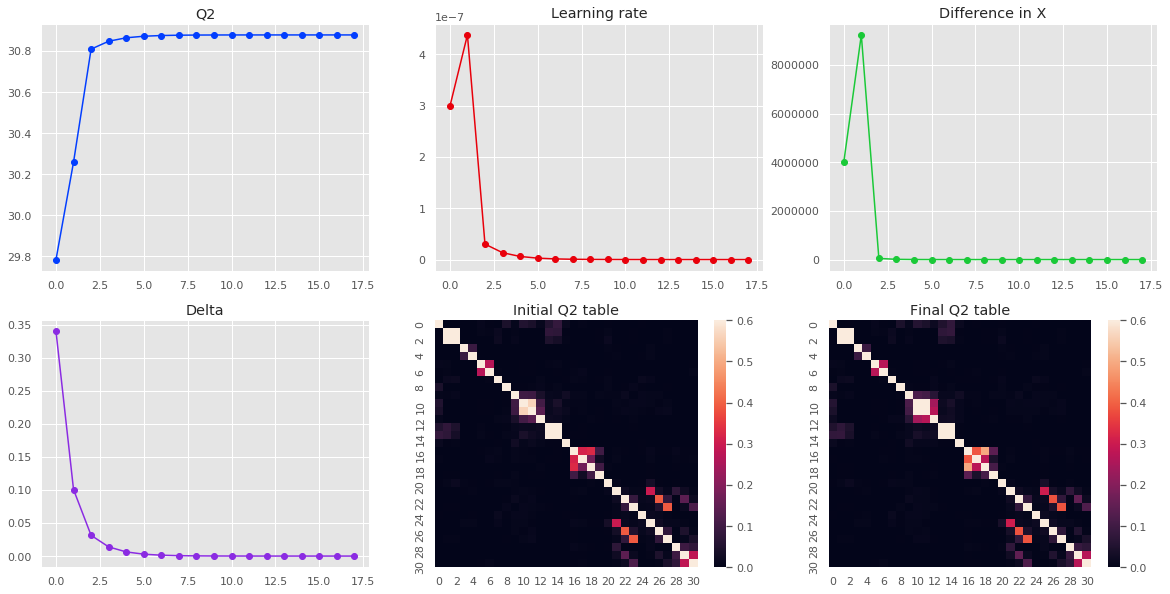

In [54]:
# Apply optimal scaling
X_before_scaling = X.copy()
X,cik = optimal_scaling(X,variable_types,verbose=True,vmax=0.6)

In [55]:
# saving the pre-processed data and encoding table

np.save(dataset_name+'_X_processed.npy',X)
np.save(dataset_name+'_cik.npy',cik)

FVE PC1 0.037702364505330065 FVE PC2 0.028841125991934304
FVE PC1 0.14733866279376784 FVE PC2 0.11270945450960862


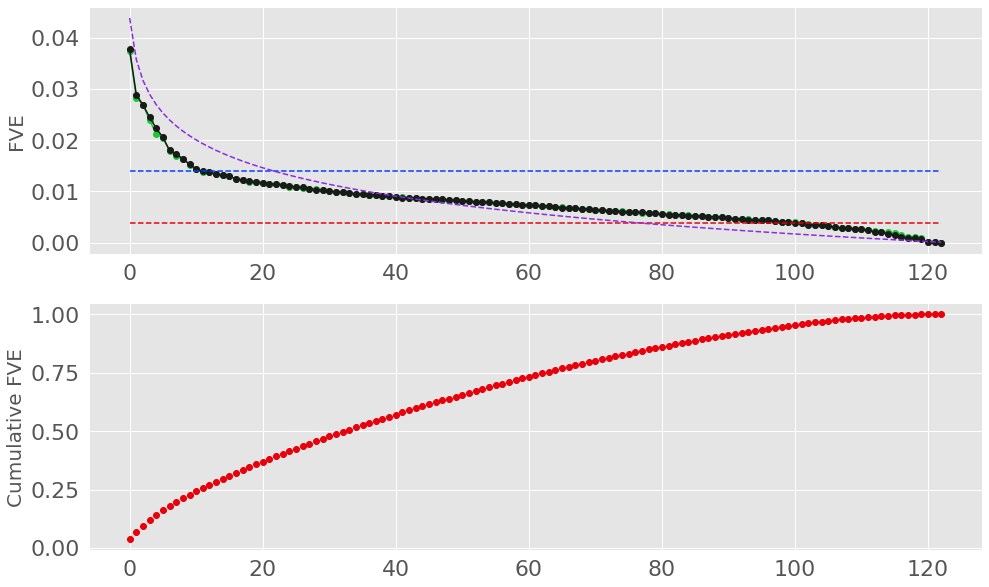

In [104]:
# reducing dimension via PCA
initial_dimension = 12

X = scipy.stats.zscore(X)

pca = PCA(n_components=X.shape[1],svd_solver='full')
Y = pca.fit_transform(X)
s = pca.explained_variance_ratio_
print('FVE PC1',s[0]/np.sum(s),'FVE PC2',s[1]/np.sum(s))
v = pca.components_.T
mean_val = np.mean(X,axis=0)

if 'X_before_scaling' in locals():
    X_before_scaling = scipy.stats.zscore(X_before_scaling)
    Ybs = pca.fit_transform(X_before_scaling)
    sbs = pca.explained_variance_ratio_
    vbs = pca.components_.T
    
fig = plt.figure(figsize=(16,10))
plt.subplot(211)
if 'X_before_scaling' in locals():
    plt.plot(sbs,'go-')
s = s/np.sum(s)
plt.plot(s,'ko-')
plt.plot([0,X.shape[1]-1],[s[0]/10,s[0]/10],'r--')
plt.plot([0,X.shape[1]-1],[s[initial_dimension-1],s[initial_dimension-1]],'b--')
plt.plot(brokenstick_distribution(len(s)),'m--')
plt.ylabel('FVE',fontsize=20)
plt.subplot(212)
plt.plot(np.cumsum(s),'ro')
plt.ylabel('Cumulative FVE',fontsize=20)

X = Y[:,0:initial_dimension]

# this is for applying ELMAP in MATLAB
ElMapFolder = '/mnt/c/MyPrograms/__github/ElMap'
if os.path.exists(ElMapFolder+'/tests/'):
    np.savetxt(ElMapFolder+'/tests/'+'_input.txt', X, delimiter="\t")
    
print('FVE PC1',s[0]/np.sum(s[0:initial_dimension]),'FVE PC2',s[1]/np.sum(s[0:initial_dimension]))

# Definition of classes, depends on the nature of complications. Major class - black - corresponds to no complications case

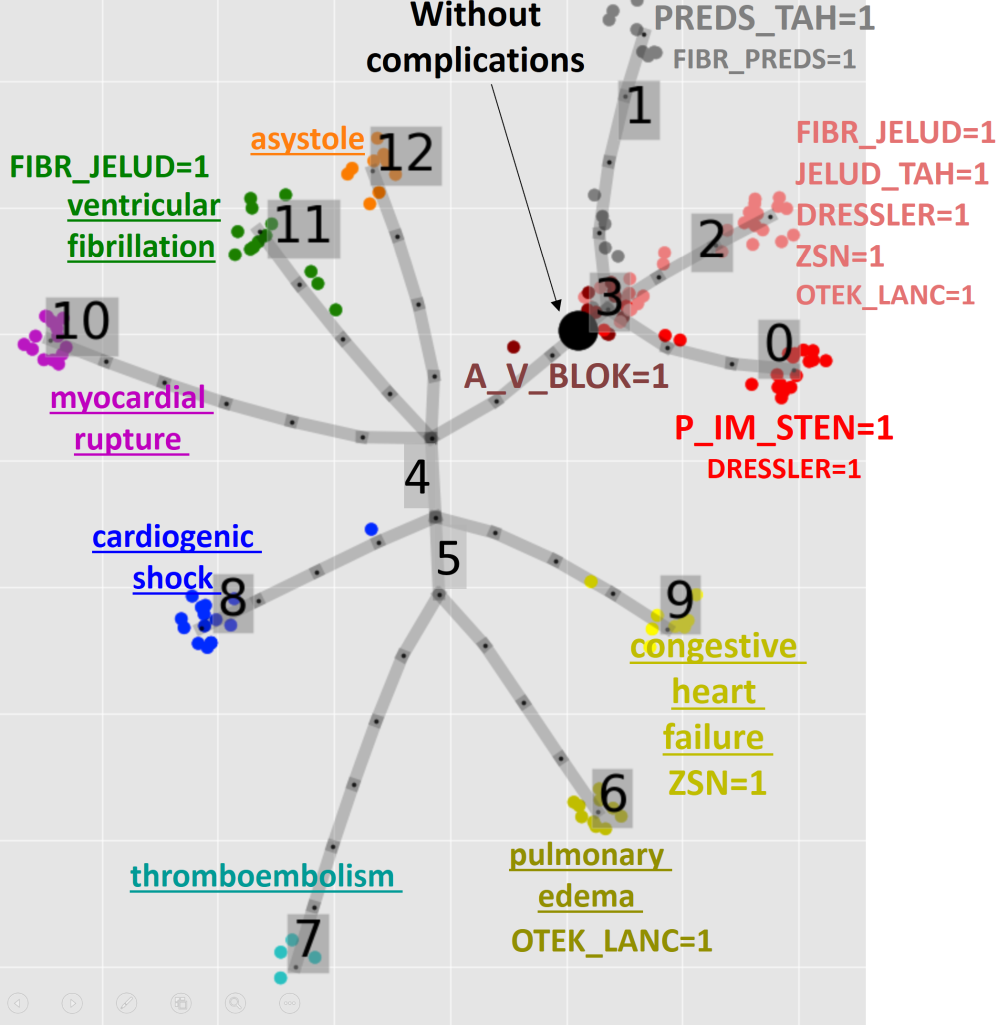

In [105]:
# Changing class colors for visualization

if True:
    clrs = []
    for c in color:
        if c==-1:
            clrs.append('k')
        if c==0:
            clrs.append('r')
        if c==1:
            clrs.append('tab:gray')
        if c==2:
            clrs.append('lightcoral')
        if c==3:
            clrs.append('darkred')
        if c==4: # this class number is absent
            clrs.append('k')
        if c==5:  # this class number is absent
            clrs.append('k')
        if c==6:
            clrs.append('y')
        if c==7:
            clrs.append('c')
        if c==8:
            clrs.append('b')
        if c==9:
            clrs.append('yellow')
        if c==10:
            clrs.append('m')
        if c==11:
            clrs.append('g')        
        if c==12:
            clrs.append('tab:orange')        
    color = clrs

if False:
    clrs = []
    for c in color:
        if c==-1:
            clrs.append('k')
        if c==1 or c==2 or c==3:
            clrs.append('r')
        if c>4:
            clrs.append('b')
    color = clrs

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
12 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  1574  points and  12  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1|7||50	17.6575	50	49	31	7	0	0	15.0075	14.9682	0.5235	0.5247	2.5854	0.0647	3.2332	161.6593	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
11.4253  seconds elapsed


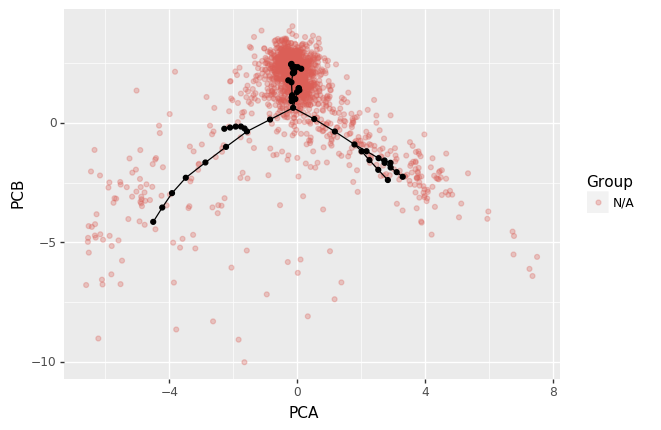

[<ggplot: (8795447135457)>]
Removed 1 vertices and 1 edges
16 labels generated


In [106]:
# Construct and post-process the principal tree

nnodes = 50

tree_elpi = elpigraph.computeElasticPrincipalTree(X,nnodes,drawPCAView=True,alpha=0.01,Mu=0.1,Lambda=0.05,FinalEnergy='Penalized')
tree_elpi = tree_elpi[0]
# some additional pruning of the graph
prune_the_tree(tree_elpi)
# extend the leafs to reach the extreme data points
tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode = "QuantDists", ControlPar = .5, DoSA = False)
# paritioning the data by tree branches
vec_labels_by_branches = partition_data_by_tree_branches(X,tree_extended)
print(len(set(vec_labels_by_branches)),'labels generated')
# paritioning the data by proximity to nodes
nodep = tree_elpi['NodePositions']
partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, MaxBlockSize = 100000000, TrimmingRadius = np.inf,SquaredX = np.sum(X**2,axis=1,keepdims=1))
partition_by_node = np.zeros(len(partition))
for i,p in enumerate(partition):
    partition_by_node[i] = p[0]

In [107]:
# Serialize the results if needed, for repeatitive use

import pickle as pkl
with open(dataset_name+'save_tree_extended.pickle', 'wb') as handle:
    pkl.dump(tree_extended, handle,protocol=pkl.HIGHEST_PROTOCOL)
with open(dataset_name+'save_X.pickle', 'wb') as handle:
    pkl.dump(X, handle,protocol=pkl.HIGHEST_PROTOCOL)
with open(dataset_name+'save_X_original.pickle', 'wb') as handle:
    pkl.dump(X_original, handle,protocol=pkl.HIGHEST_PROTOCOL)


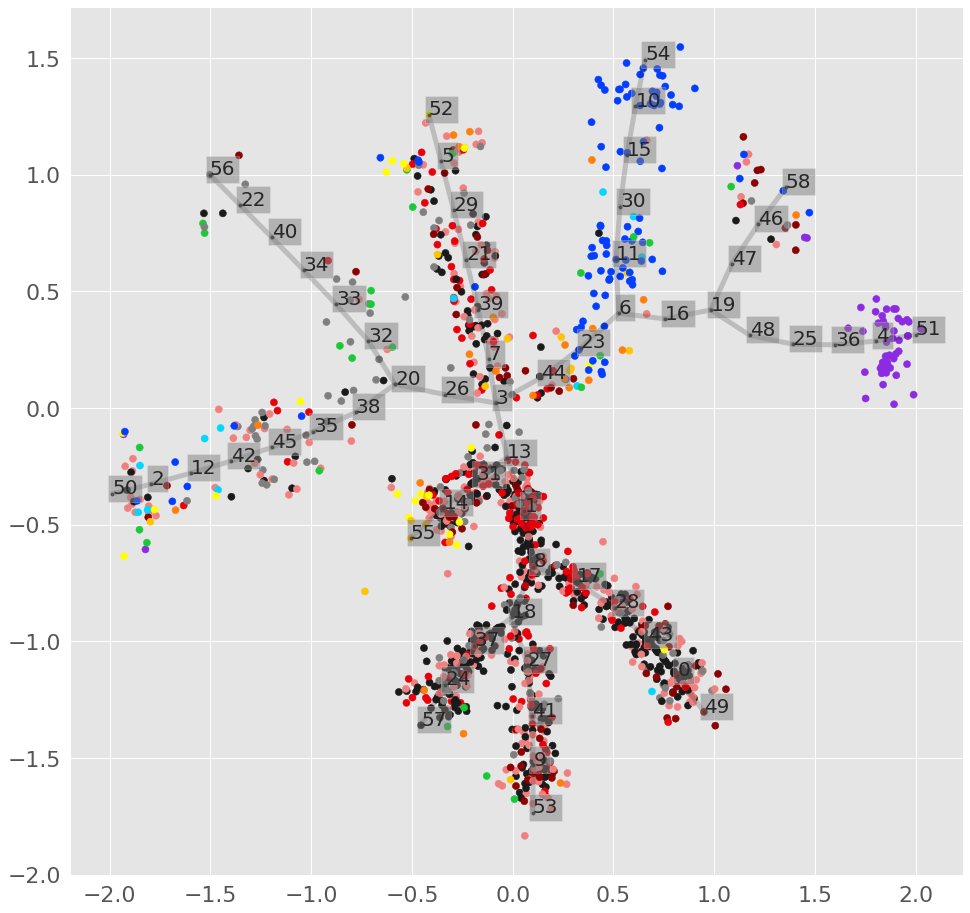

In [109]:
showEdgeNumbers=False
showNodeNumbers=True
showBranchNumbers=False
showPointNumbers=False
Color_by_feature = ''
Feature_Edge_Width = ''
Invert_Edge_Value = False
Min_Edge_Width = 5
Max_Edge_Width = 5
Big_Point_Size = 1000
Small_Point_Size = 100
Normal_Point_Size = 50
Visualize_Edge_Width_AsNodeCoordinates=True
Color_by_partitioning = False
Transparency_Alpha = 0.2
Visualize_Branch_Class_Associations = [] #list_of_branch_class_associations
cmap = 'hot'
highlight_subset = []
Color_by_partitioning=False
partitioning = vec_labels_by_branches
scatter_parameter = 0.03

sns.set(palette='bright',font_scale=2)

#feature = 'LET_IS_0'
feature = ''
fig = plt.figure(figsize=(16, 16))
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,Color_by_feature=feature, Feature_Edge_Width=feature,Invert_Edge_Value=Invert_Edge_Value,Min_Edge_Width=Min_Edge_Width,Max_Edge_Width=Max_Edge_Width,Visualize_Edge_Width_AsNodeCoordinates=Visualize_Edge_Width_AsNodeCoordinates, Color_by_partitioning=Color_by_partitioning, visualize_partition=partitioning, showBranchNumbers=showBranchNumbers,showNodeNumbers=showNodeNumbers,scatter_parameter=scatter_parameter,cmap=cmap,Normal_Point_Size=Normal_Point_Size,highlight_subset=highlight_subset,Big_Point_Size=Big_Point_Size,showPointNumbers=showPointNumbers,Visualize_Branch_Class_Associations=Visualize_Branch_Class_Associations)
plt.savefig('principal_tree.png', format='png', dpi=300)

In [111]:
# Associate nodes (vec_labels_by_branches) and classes (color)
# The aim is to identify the root_node (the node most enriched with 'k' class - which means no complications)

Negative_Enrichment = False
Threshold_Deviation = 0.2
Minimal_number_of_points = 20
partitioning = partition_by_node

list_of_node_class_associations,p,stat = associate_with_categorical_var(partitioning,'CLASS',color,'CATEGORICAL',
                                                            score_threshold=Threshold_Deviation,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points)
    
print(list_of_node_class_associations)

k_nodes_scores = [(asst[0],asst[2]) for asst in list_of_node_class_associations if asst[1]=='k']
max_score_node = int(k_nodes_scores[np.argmax([t[1] for t in k_nodes_scores])][0])

root_node = max_score_node

print('Suggested root_node=',root_node)
root_node = 8
print('Selected root_node=',root_node)

[(0.0, 'lightcoral', 0.22575228453573123), (1.0, 'k', 0.20045760772848606), (1.0, 'r', 0.29054592661762363), (4.0, 'm', 0.9348494161032577), (8.0, 'k', 0.3070984908186525), (9.0, 'lightcoral', 0.24970226280269944), (10.0, 'b', 0.8816497310221159), (11.0, 'b', 0.8604778032868867), (14.0, 'lightcoral', 0.2887714466485541), (37.0, 'k', 0.3186102103750352), (43.0, 'k', 0.2536430353616216)]
Suggested root_node= 37
Selected root_node= 8


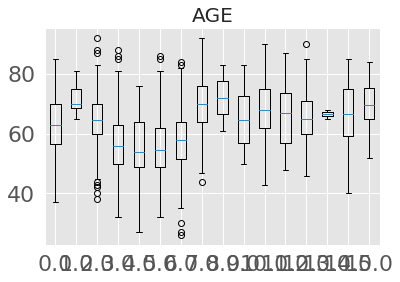

AGE CONTINUOUS [(7.0, 'CONTINUOUS', 0.5393853176237711), (15.0, 'CONTINUOUS', 0.5691517794142528)] p-value= 7.026982668968674e-77


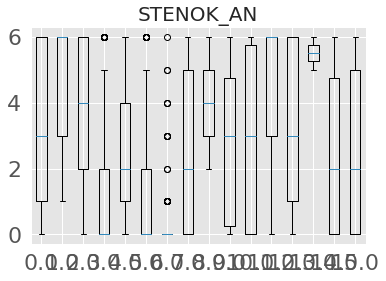

STENOK_AN ORDINAL [(11.0, 'CONTINUOUS', 0.6015416331408815)] p-value= 3.946557408516603e-93


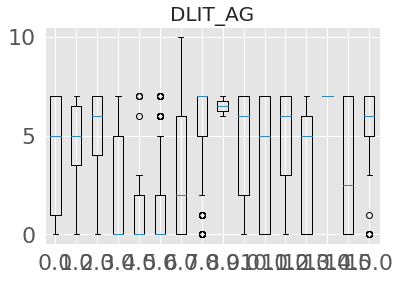

DLIT_AG ORDINAL [(7.0, 'CONTINUOUS', 0.5929823619677199)] p-value= 7.46473210931981e-84


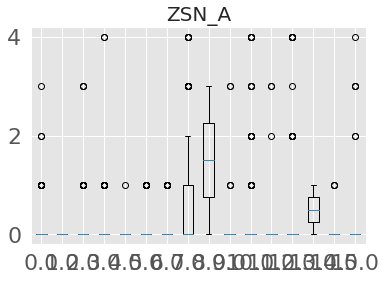

ZSN_A ORDINAL [(7.0, 'CONTINUOUS', 0.5771715838829472), (8.0, 'CONTINUOUS', 2.1018116782860363), (10.0, 'CONTINUOUS', 0.6191222991361365), (12.0, 'CONTINUOUS', 0.5817419561140291)] p-value= 8.908392667161276e-21


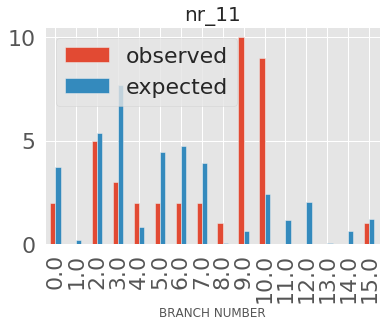

nr_11 BINARY [(9.0, 1.0, 0.8789542795750269)] p-value= 2.3887246632196808e-32


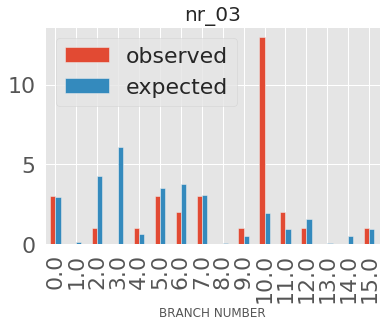

nr_03 BINARY [(10.0, 1.0, 0.7414468085106382)] p-value= 2.120316491090152e-10


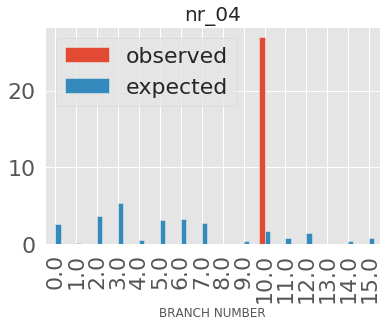

nr_04 BINARY [(10.0, 1.0, 0.8827751196172248)] p-value= 8.892058643832203e-79


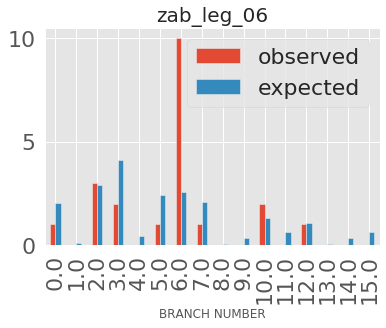

zab_leg_06 BINARY [(6.0, 1.0, 0.5938433497038124)] p-value= 0.02104385152487836


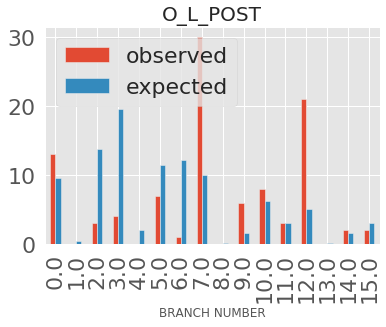

O_L_POST BINARY [(7.0, 1.0, 0.5009535918626828), (12.0, 1.0, 0.6063566117509842)] p-value= 7.305370468377645e-24


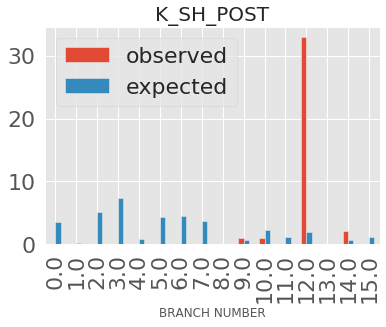

K_SH_POST BINARY [(12.0, 1.0, 0.890897176868891)] p-value= 5.703377522716266e-109


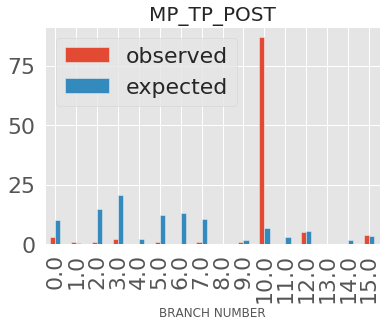

MP_TP_POST BINARY [(10.0, 1.0, 0.858979406214789)] p-value= 1.3412584808458813e-231


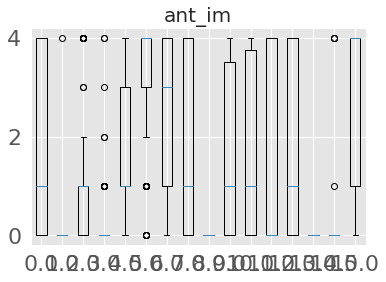

ant_im ORDINAL [(5.0, 'CONTINUOUS', 0.9033789997244981), (15.0, 'CONTINUOUS', 0.5512756514524735)] p-value= 3.1884893176983037e-122


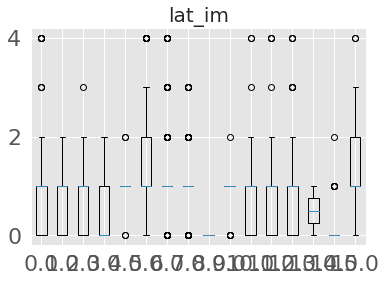

lat_im ORDINAL [(5.0, 'CONTINUOUS', 0.8956553845440965), (6.0, 'CONTINUOUS', 0.5529917442381573), (15.0, 'CONTINUOUS', 0.6751831578409997)] p-value= 2.5302166292393875e-78


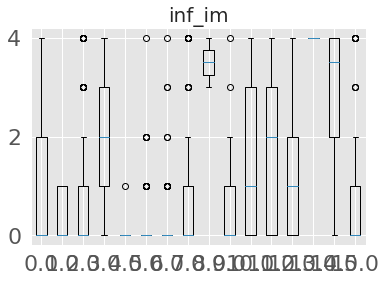

inf_im ORDINAL [(3.0, 'CONTINUOUS', 0.8586582510591311), (8.0, 'CONTINUOUS', 1.8073937300904093), (11.0, 'CONTINUOUS', 0.5691367490497421), (13.0, 'CONTINUOUS', 2.168872476108475), (14.0, 'CONTINUOUS', 1.306884697142288)] p-value= 1.1216412130589728e-116


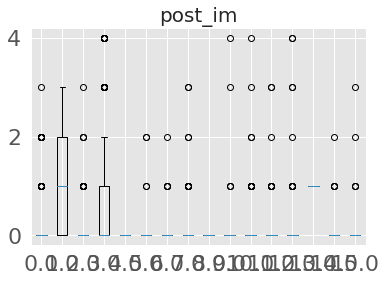

post_im ORDINAL [(1.0, 'CONTINUOUS', 1.2388966401222041), (3.0, 'CONTINUOUS', 0.6169216246976803)] p-value= 4.5709484934119987e-38


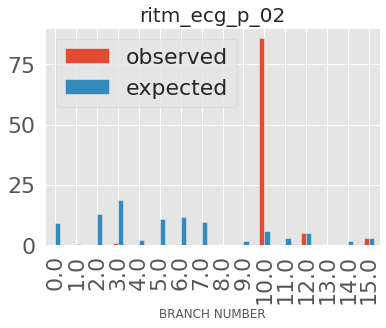

ritm_ecg_p_02 BINARY [(10.0, 1.0, 0.8712968467036233)] p-value= 9.078276058976477e-255


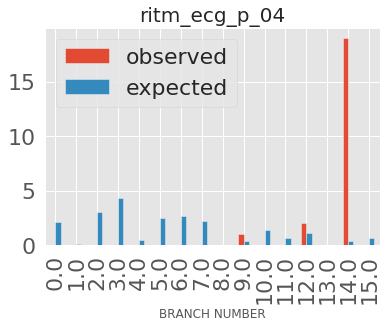

ritm_ecg_p_04 BINARY [(14.0, 1.0, 0.9624647286567358)] p-value= 8.831296076911453e-202


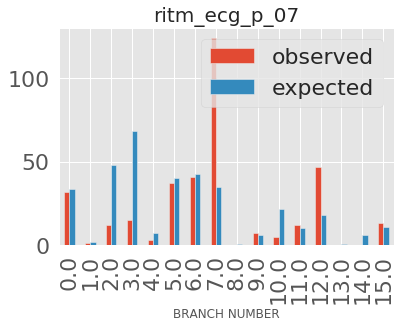

ritm_ecg_p_07 BINARY [(7.0, 1.0, 0.5616016386031867)] p-value= 3.5607091008710603e-91


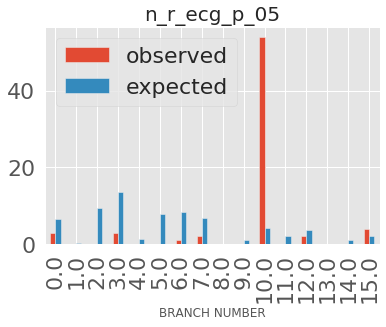

n_r_ecg_p_05 BINARY [(10.0, 1.0, 0.8526123062839208)] p-value= 9.606297624385901e-129


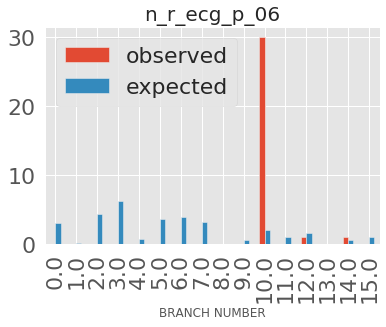

n_r_ecg_p_06 BINARY [(10.0, 1.0, 0.8754468186512034)] p-value= 2.0970943671952486e-82


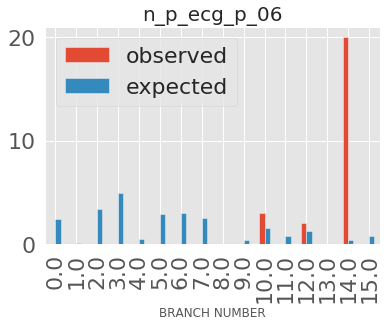

n_p_ecg_p_06 BINARY [(14.0, 1.0, 0.9595393713040773)] p-value= 1.029225427893389e-196


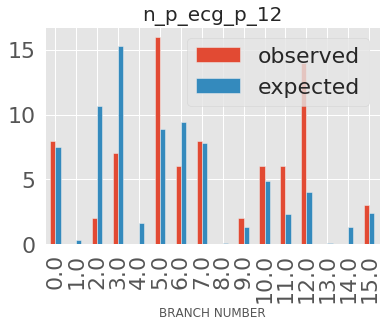

n_p_ecg_p_12 BINARY [(12.0, 1.0, 0.5543485927911406)] p-value= 1.1083449854800863e-06


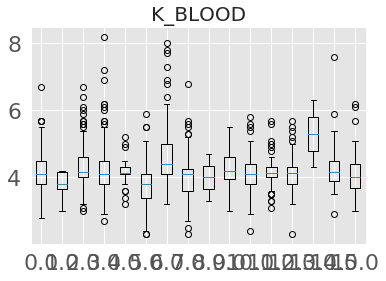

K_BLOOD CONTINUOUS [(6.0, 'CONTINUOUS', 0.7808050689329693)] p-value= 1.7962476144357983e-32


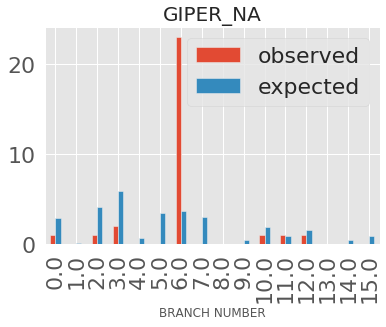

GIPER_NA BINARY [(6.0, 1.0, 0.7267003720309072)] p-value= 1.1105544340997174e-18


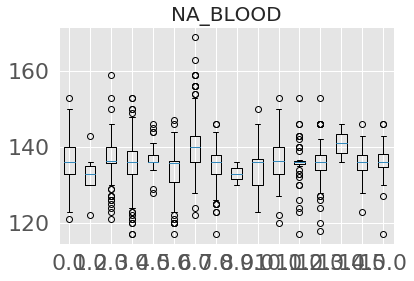

NA_BLOOD CONTINUOUS [(6.0, 'CONTINUOUS', 0.7424700521140493)] p-value= 2.6944592667990514e-27


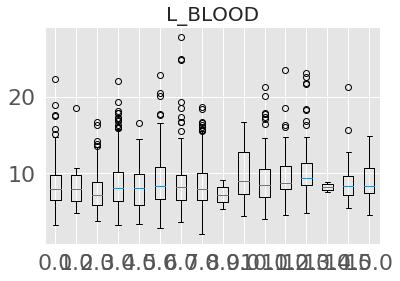

L_BLOOD CONTINUOUS [(12.0, 'CONTINUOUS', 0.601492296211269)] p-value= 5.434335114108138e-08


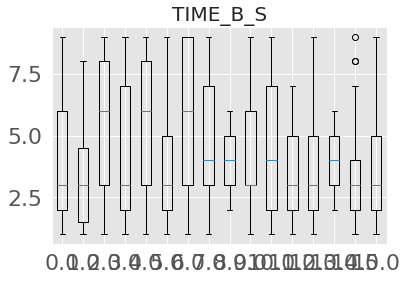

TIME_B_S ORDINAL [(6.0, 'CONTINUOUS', 0.6025361833307956)] p-value= 1.5796436713118018e-21


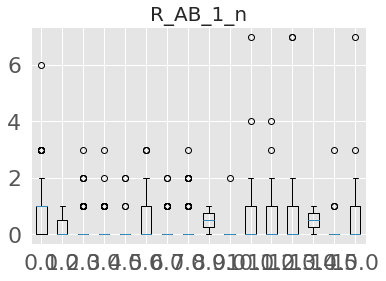

R_AB_1_n ORDINAL [(0.0, 'CONTINUOUS', 0.7430067006215699)] p-value= 5.365032330614699e-36


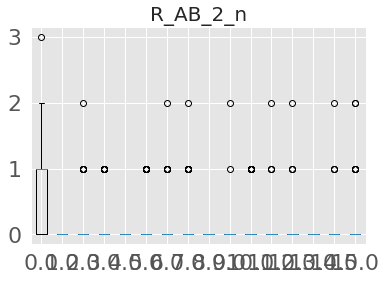

R_AB_2_n ORDINAL [(0.0, 'CONTINUOUS', 1.6200253649891396)] p-value= 3.2402721253594724e-103


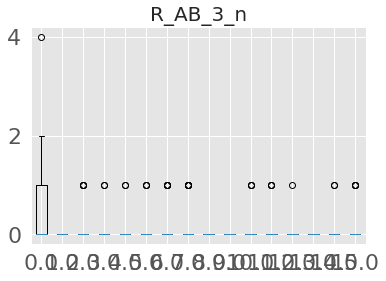

R_AB_3_n ORDINAL [(0.0, 'CONTINUOUS', 1.4240309566240765)] p-value= 3.87855192319837e-73


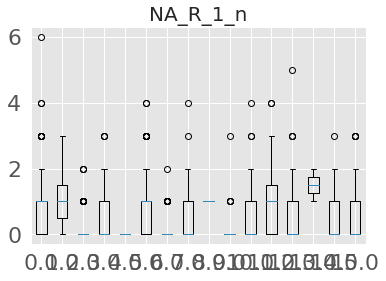

NA_R_1_n ORDINAL [(0.0, 'CONTINUOUS', 0.5673390663487825)] p-value= 8.758107549085469e-40


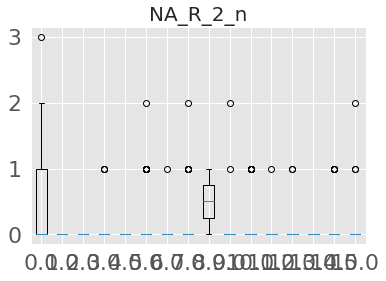

NA_R_2_n ORDINAL [(0.0, 'CONTINUOUS', 1.5705096905042055)] p-value= 4.259699120045731e-97


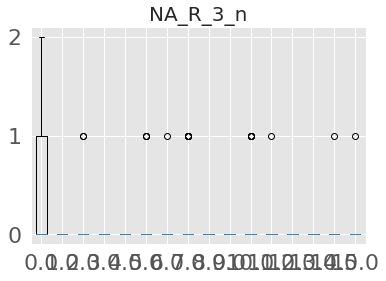

NA_R_3_n ORDINAL [(0.0, 'CONTINUOUS', 1.3791554387892861)] p-value= 2.1564418807891218e-67


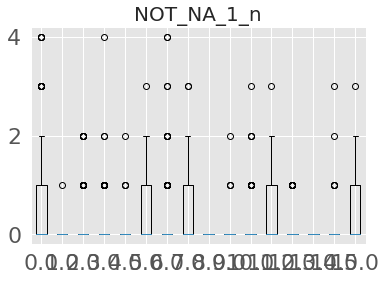

NOT_NA_1_n ORDINAL [(0.0, 'CONTINUOUS', 0.6035676789158306)] p-value= 4.062940653820798e-14


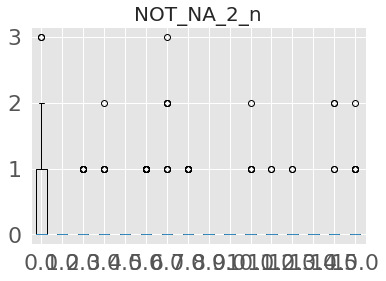

NOT_NA_2_n ORDINAL [(0.0, 'CONTINUOUS', 1.287232356443516)] p-value= 1.3720574861495647e-59


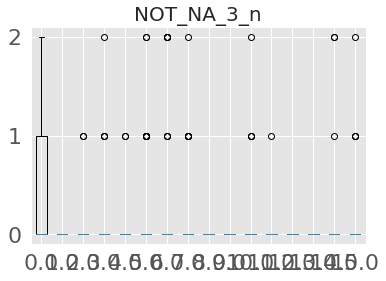

NOT_NA_3_n ORDINAL [(0.0, 'CONTINUOUS', 1.1611813807090618)] p-value= 5.3013388997915115e-46


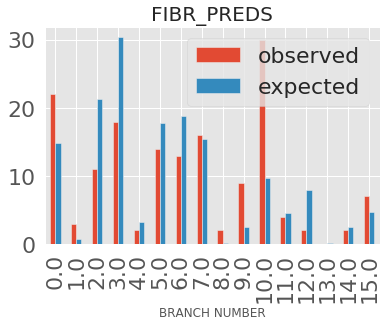

FIBR_PREDS BINARY [(10.0, 1.0, 0.5132190354109919)] p-value= 5.959886919216982e-18


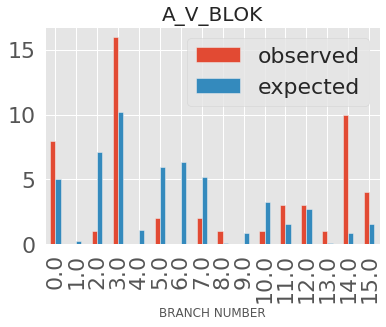

A_V_BLOK BINARY [(14.0, 1.0, 0.841797332085186)] p-value= 3.910399069907525e-26


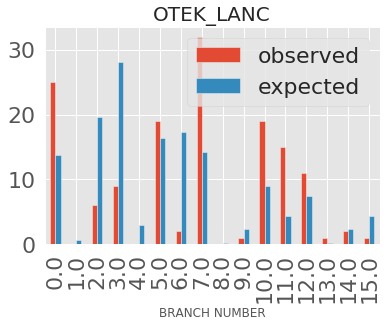

OTEK_LANC BINARY [(11.0, 1.0, 0.5568230523227061)] p-value= 1.4899053594805018e-20


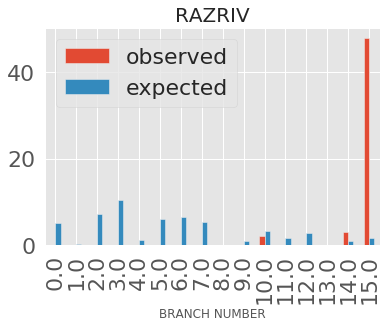

RAZRIV BINARY [(15.0, 1.0, 0.9348494161032577)] p-value= 1.926898836597545e-296


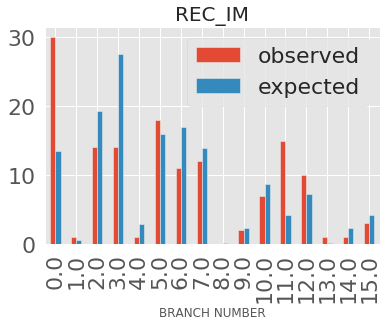

REC_IM BINARY [(11.0, 1.0, 0.5640940708843988)] p-value= 9.571545280744568e-10


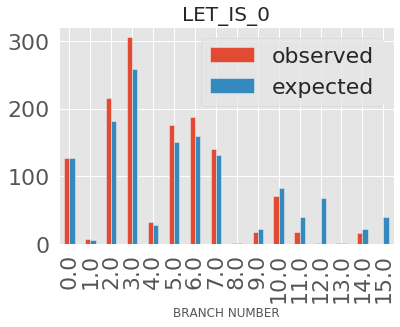

LET_IS_0 BINARY [(11.0, 0.0, 0.5866659714618421), (12.0, 0.0, 0.7170237297965326), (15.0, 0.0, 0.7230432402846196)] p-value= 2.201433451208831e-183


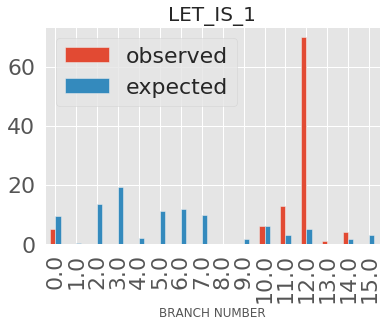

LET_IS_1 BINARY [(11.0, 1.0, 0.629464463468047), (12.0, 1.0, 0.8643135728728668)] p-value= 1.1394098348628267e-205


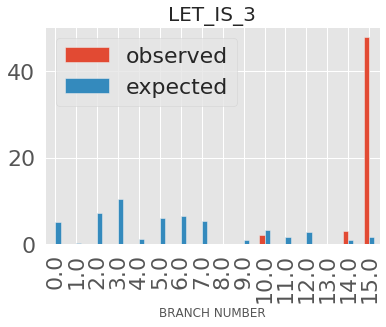

LET_IS_3 BINARY [(15.0, 1.0, 0.9348494161032577)] p-value= 1.926898836597545e-296


In [112]:
# Associate branches (vec_labels_by_branches) and variables (chi-square : binary, ordinal and categorical
# and ANOVA for continuous)

reload(clintraj_util)
from clintraj_util import associate_with_categorical_var


Negative_Enrichment = False
Threshold_Deviation = 0.5
Threshold_Parameter = 0.5
Minimal_number_of_points = 10
pvalue_threshold_parameter = 0.01
produce_plots = True

all_branch_var_associations = {}

for k,var in enumerate(variable_names):
    var_type = variable_types[k]
    vals = X_original[:,k]
    list_of_branch_var_associations=[]
    if var_type=='BINARY' or var_type=='CATEGORICAL':
        list_of_branch_var_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,var,vals,var_type,
                                                            score_threshold=Threshold_Deviation,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                            pvalue_threshold_parameter=pvalue_threshold_parameter,
                                                            produce_plot=produce_plots)
    if var_type=='ORDINAL' or var_type=='CONTINUOUS':
        list_of_branch_var_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,var,vals,var_type,
                                                            score_threshold=Threshold_Parameter,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                            pvalue_threshold_parameter=pvalue_threshold_parameter,
                                                            produce_plot=produce_plots)
    if len(list_of_branch_var_associations)>0:
        print(var,var_type,list_of_branch_var_associations,'p-value=',p)
        all_branch_var_associations[var] = list_of_branch_var_associations

['post_im', 'MP_TP_POST', 'n_r_ecg_p_06', 'n_r_ecg_p_05', 'nr_03', 'nr_04', 'ritm_ecg_p_02', 'FIBR_PREDS', 'A_V_BLOK', 'ritm_ecg_p_04', 'n_p_ecg_p_06', 'ZSN_A', 'inf_im', 'REC_IM', 'STENOK_AN', 'OTEK_LANC', 'LET_IS_0', 'O_L_POST', 'LET_IS_1', 'L_BLOOD', 'K_SH_POST', 'n_p_ecg_p_12', 'NA_BLOOD', 'zab_leg_06', 'K_BLOOD', 'GIPER_NA', 'TIME_B_S', 'DLIT_AG', 'ritm_ecg_p_07', 'ant_im', 'lat_im', 'AGE', 'RAZRIV', 'LET_IS_3', 'nr_11', 'NA_R_3_n', 'NOT_NA_3_n', 'R_AB_3_n', 'NA_R_2_n', 'NA_R_1_n', 'R_AB_1_n', 'R_AB_2_n', 'NOT_NA_1_n', 'NOT_NA_2_n']



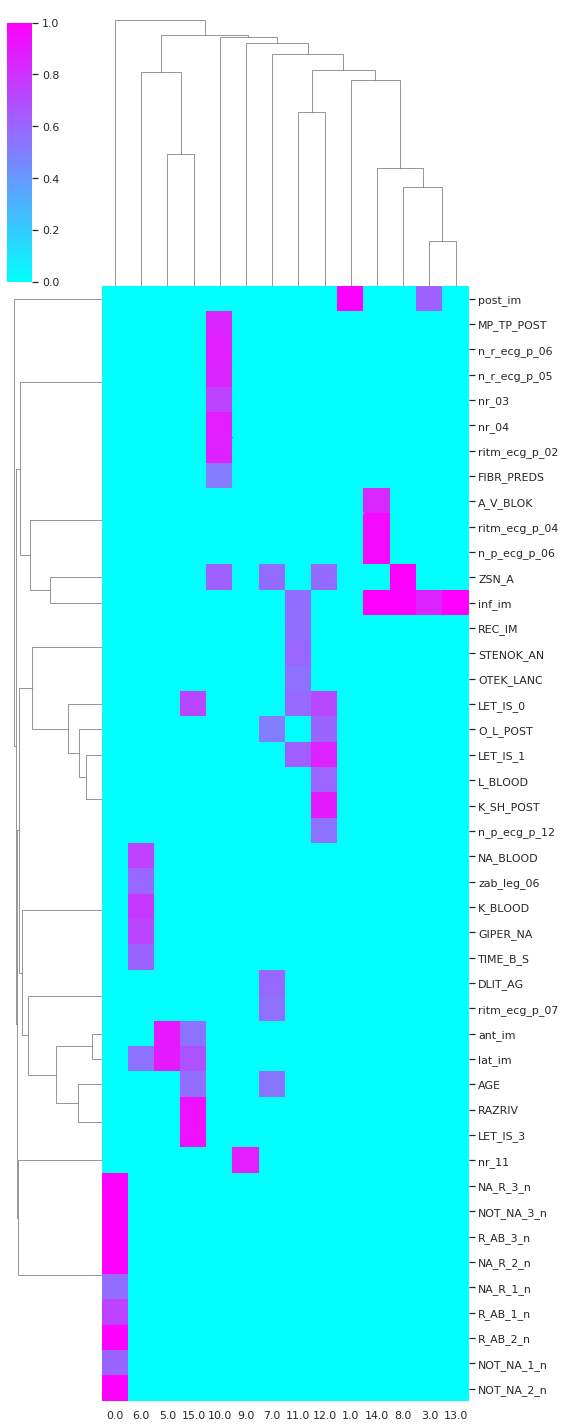

In [113]:
# Visualize associations between variables and tree branches

matrix_of_scores,keys,objects = get_matrix_of_association_scores(all_branch_var_associations)

sns.set(color_codes=True)
#g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20),vmax=1,cmap='cool')
objects_reordered = [objects[ind] for ind in g.dendrogram_col.reordered_ind]
keys_reordered = [keys[ind] for ind in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_xticklabels(objects_reordered)
g.ax_heatmap.set_yticklabels(keys_reordered)
print(keys_reordered)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig('assoc_branches.png', format='png', dpi=300)
print()

In [114]:
reload(clintraj_eltree)
from clintraj_eltree import convert_elpigraph_to_igraph

# Quantify pseudo-time

all_trajectories = extract_trajectories(tree_extended,root_node)
print(len(all_trajectories),' trajectories found.')
ProjStruct = project_on_tree(X,tree_extended)
PseudoTimeTraj = quantify_pseudotime(all_trajectories,ProjStruct)
# add information about bifurcation points
g = convert_elpigraph_to_igraph(tree_extended)
degs = g.degree()
for pss in PseudoTimeTraj:
    traj = pss['Trajectory']
    branching_marks = []
    for i,n in enumerate(traj):
        if degs[n]>2 and i>0:
            branching_marks.append(i)
    pss['BranchingPoints'] = branching_marks
    #print(n,branching_marks)

10  trajectories found.


/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zinovyev/anaconda3/lib/python3.

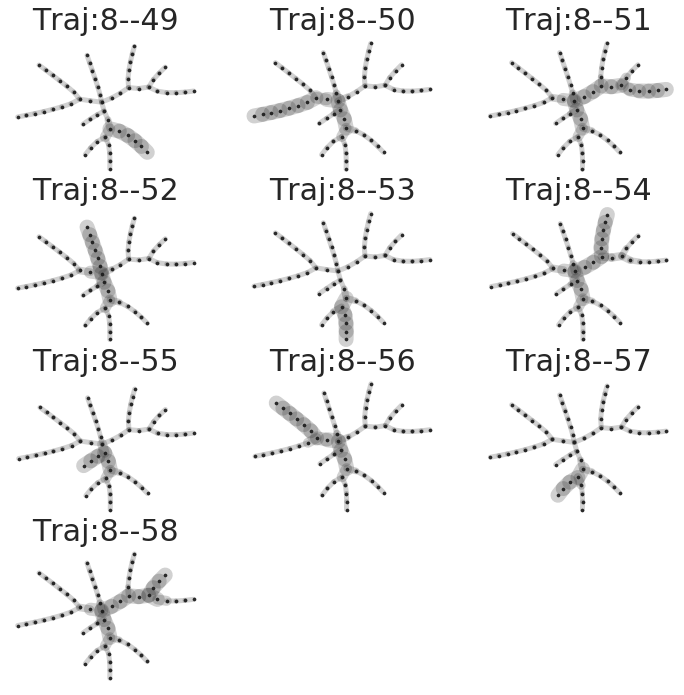

In [115]:
# Visualize all trajectories
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

n_subplots_x, n_subplots_y = 4, 3
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 12))

for i,pstt in enumerate(PseudoTimeTraj):
    points = list(pstt['Points'])
    X_fake = np.zeros((X.shape[0],1))
    X_fake[points,0] = 1.0
    TrajName = 'Traj:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i+1)
    plt.title(TrajName,fontsize=30)
    visualize_eltree_with_data(tree_extended,X,X_fake,v,mean_val,color,['Traj'],
                          Min_Edge_Width=5,Max_Edge_Width=15,Normal_Point_Size = 0,
                          Color_by_feature='', Feature_Edge_Width='Traj',
                          Visualize_Edge_Width_AsNodeCoordinates=False)
    plt.axis('off')
    plt.savefig('trajectories.png', format='png', dpi=300)



/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


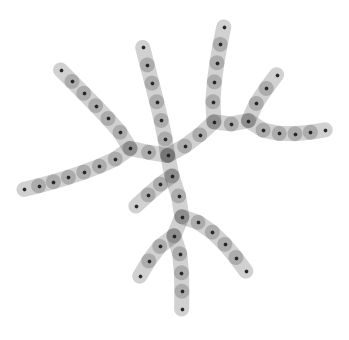

In [116]:
# produce principal tree scaffold image

fig = plt.figure(figsize=(6, 6))
visualize_eltree_with_data(tree_extended,X,X_fake,v,mean_val,color,['Traj'],
                          Min_Edge_Width=15,Max_Edge_Width=15,Normal_Point_Size = 0,
                          Color_by_feature='', Feature_Edge_Width='Traj',
                          Visualize_Edge_Width_AsNodeCoordinates=False)
plt.axis('off')
plt.savefig('tree_structure.png', format='png', dpi=600)


AGE CONTINUOUS
SEX BINARY
INF_ANAM ORDINAL
STENOK_AN ORDINAL


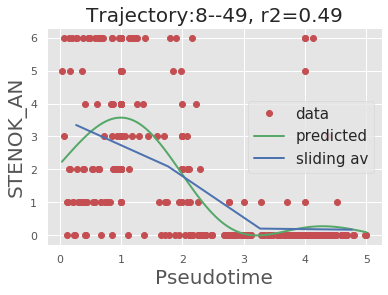

0 ('Trajectory:8--49', 'STENOK_AN', 0.4943379774069555)


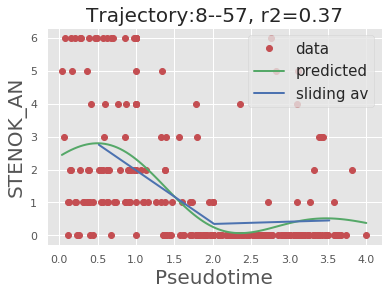

8 ('Trajectory:8--57', 'STENOK_AN', 0.36973804804655375)
[('Trajectory:8--49', 'STENOK_AN', 0.4943379774069555), ('Trajectory:8--57', 'STENOK_AN', 0.36973804804655375)]
FK_STENOK ORDINAL


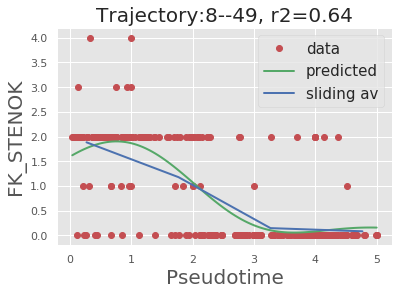

0 ('Trajectory:8--49', 'FK_STENOK', 0.6362446703609395)


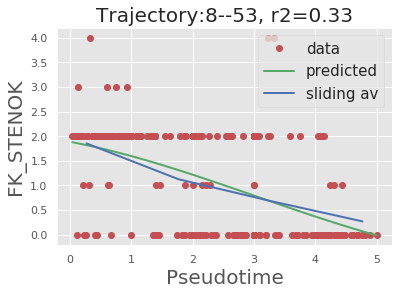

4 ('Trajectory:8--53', 'FK_STENOK', 0.33374550801951286)


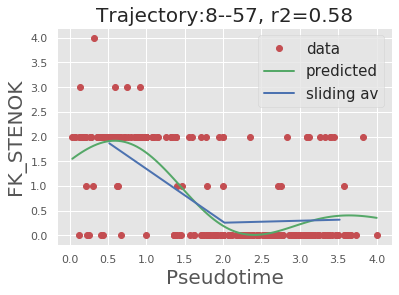

8 ('Trajectory:8--57', 'FK_STENOK', 0.5759645649058704)
[('Trajectory:8--49', 'FK_STENOK', 0.6362446703609395), ('Trajectory:8--53', 'FK_STENOK', 0.33374550801951286), ('Trajectory:8--57', 'FK_STENOK', 0.5759645649058704)]
IBS_POST ORDINAL


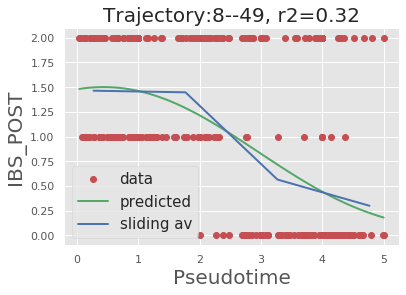

0 ('Trajectory:8--49', 'IBS_POST', 0.31516377189357725)
[('Trajectory:8--49', 'IBS_POST', 0.31516377189357725)]
GB ORDINAL
SIM_GIPERT BINARY
DLIT_AG ORDINAL
ZSN_A ORDINAL
nr_11 BINARY
nr_01 BINARY
nr_02 BINARY
nr_03 BINARY
nr_04 BINARY


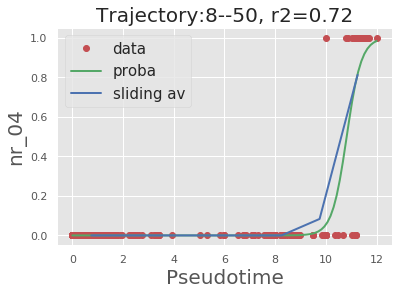

1 ('Trajectory:8--50', 'nr_04', 0.7208543771043772)
[('Trajectory:8--50', 'nr_04', 0.7208543771043772)]
nr_07 BINARY
nr_08 BINARY
np_01 BINARY
np_04 BINARY
np_05 BINARY
np_07 BINARY
np_08 BINARY
np_09 BINARY
np_10 BINARY


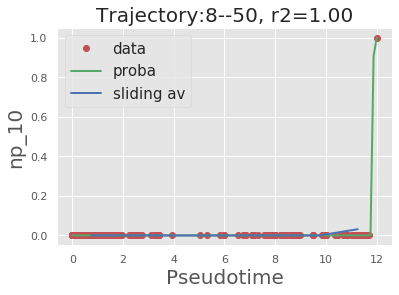

1 ('Trajectory:8--50', 'np_10', 1.0)
[('Trajectory:8--50', 'np_10', 1.0)]
endocr_01 BINARY
endocr_02 BINARY
endocr_03 BINARY
zab_leg_01 BINARY
zab_leg_02 BINARY
zab_leg_03 BINARY
zab_leg_04 BINARY
zab_leg_06 BINARY
S_AD_ORIT CONTINUOUS


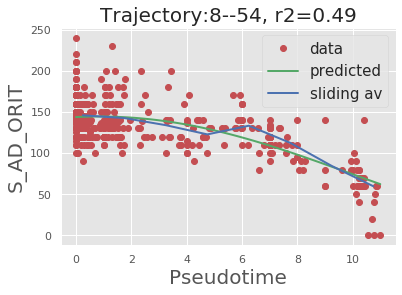

5 ('Trajectory:8--54', 'S_AD_ORIT', 0.49305166612476703)
[('Trajectory:8--54', 'S_AD_ORIT', 0.49305166612476703)]
D_AD_ORIT CONTINUOUS


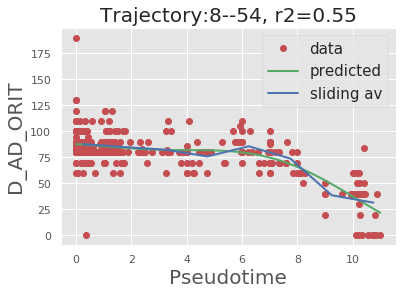

5 ('Trajectory:8--54', 'D_AD_ORIT', 0.5499136710733925)
[('Trajectory:8--54', 'D_AD_ORIT', 0.5499136710733925)]
O_L_POST BINARY
K_SH_POST BINARY


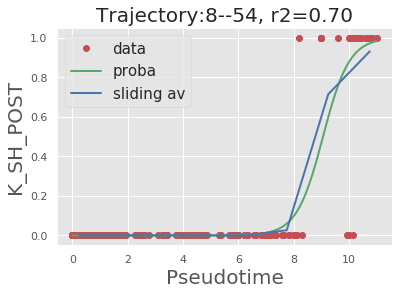

5 ('Trajectory:8--54', 'K_SH_POST', 0.7030139671649106)
[('Trajectory:8--54', 'K_SH_POST', 0.7030139671649106)]
MP_TP_POST BINARY


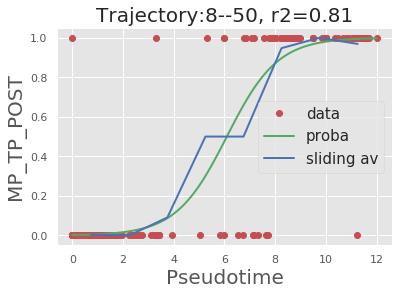

1 ('Trajectory:8--50', 'MP_TP_POST', 0.8091049980627664)
[('Trajectory:8--50', 'MP_TP_POST', 0.8091049980627664)]
SVT_POST BINARY


/mnt/c/Datas/Golovenkin/clintraj_util.py:101: RuntimeWarning: invalid value encountered in true_divide
  bin_avgs = vals / counts


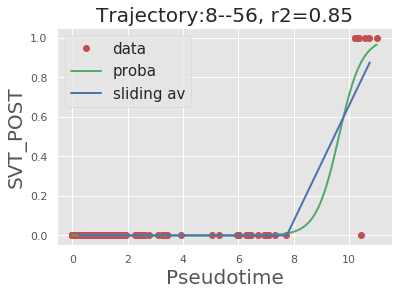

7 ('Trajectory:8--56', 'SVT_POST', 0.8538315988647114)
[('Trajectory:8--56', 'SVT_POST', 0.8538315988647114)]
GT_POST BINARY
FIB_G_POST BINARY


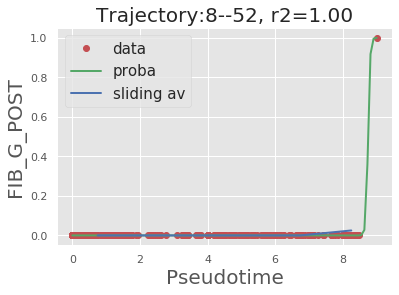

3 ('Trajectory:8--52', 'FIB_G_POST', 1.0)
[('Trajectory:8--52', 'FIB_G_POST', 1.0)]
ant_im ORDINAL


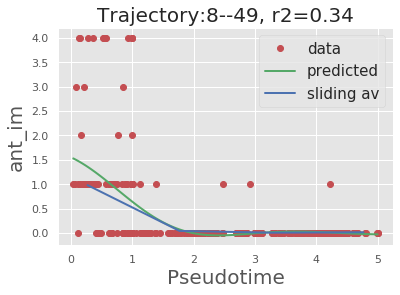

0 ('Trajectory:8--49', 'ant_im', 0.3449898503164226)
[('Trajectory:8--49', 'ant_im', 0.3449898503164226)]
lat_im ORDINAL
inf_im ORDINAL


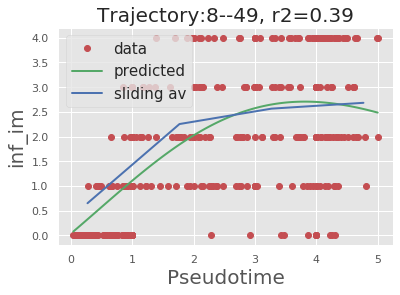

0 ('Trajectory:8--49', 'inf_im', 0.3884826327480385)
[('Trajectory:8--49', 'inf_im', 0.3884826327480385)]
post_im ORDINAL
IM_PG_P BINARY
ritm_ecg_p_01 BINARY


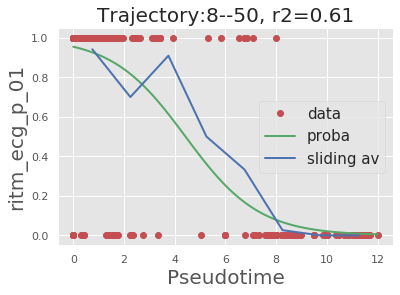

1 ('Trajectory:8--50', 'ritm_ecg_p_01', 0.6130105401844532)


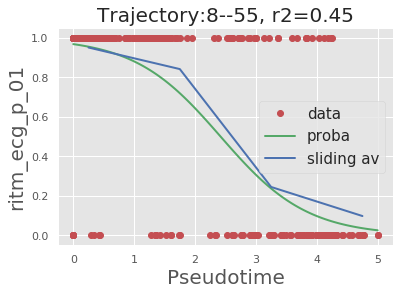

6 ('Trajectory:8--55', 'ritm_ecg_p_01', 0.45020283975659225)
[('Trajectory:8--50', 'ritm_ecg_p_01', 0.6130105401844532), ('Trajectory:8--55', 'ritm_ecg_p_01', 0.45020283975659225)]
ritm_ecg_p_02 BINARY


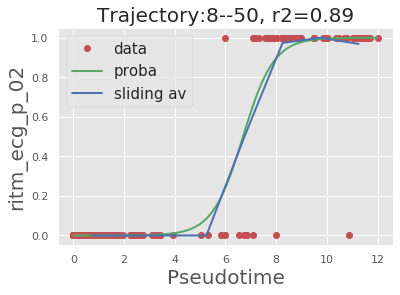

1 ('Trajectory:8--50', 'ritm_ecg_p_02', 0.8947138661798556)
[('Trajectory:8--50', 'ritm_ecg_p_02', 0.8947138661798556)]
ritm_ecg_p_04 BINARY


/mnt/c/Datas/Golovenkin/clintraj_util.py:101: RuntimeWarning: invalid value encountered in true_divide
  bin_avgs = vals / counts


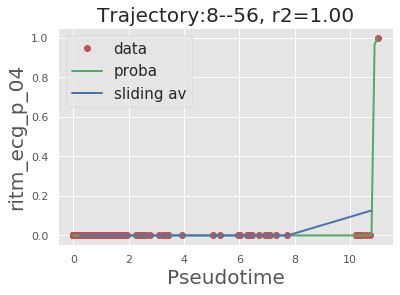

7 ('Trajectory:8--56', 'ritm_ecg_p_04', 1.0)


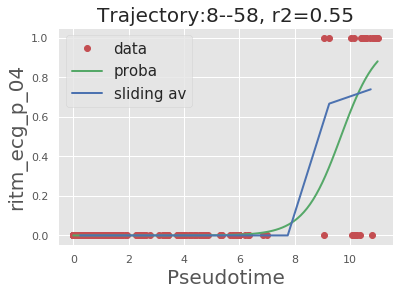

9 ('Trajectory:8--58', 'ritm_ecg_p_04', 0.5549952726126695)
[('Trajectory:8--56', 'ritm_ecg_p_04', 1.0), ('Trajectory:8--58', 'ritm_ecg_p_04', 0.5549952726126695)]
ritm_ecg_p_06 BINARY
ritm_ecg_p_07 BINARY


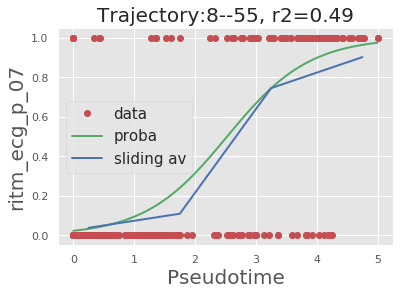

6 ('Trajectory:8--55', 'ritm_ecg_p_07', 0.4909615084930653)
[('Trajectory:8--55', 'ritm_ecg_p_07', 0.4909615084930653)]
ritm_ecg_p_08 BINARY
n_r_ecg_p_01 BINARY
n_r_ecg_p_02 BINARY
n_r_ecg_p_03 BINARY
n_r_ecg_p_04 BINARY
n_r_ecg_p_05 BINARY


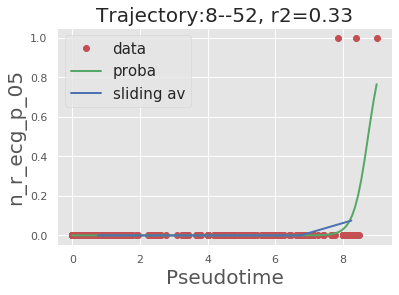

3 ('Trajectory:8--52', 'n_r_ecg_p_05', 0.32861635220125796)
[('Trajectory:8--52', 'n_r_ecg_p_05', 0.32861635220125796)]
n_r_ecg_p_06 BINARY


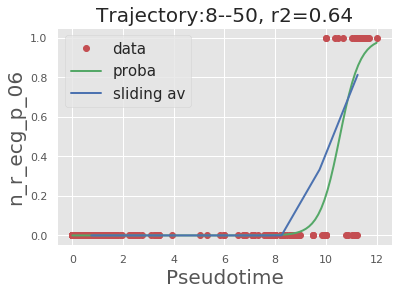

1 ('Trajectory:8--50', 'n_r_ecg_p_06', 0.638013371537727)
[('Trajectory:8--50', 'n_r_ecg_p_06', 0.638013371537727)]
n_r_ecg_p_08 BINARY


/mnt/c/Datas/Golovenkin/clintraj_util.py:101: RuntimeWarning: invalid value encountered in true_divide
  bin_avgs = vals / counts


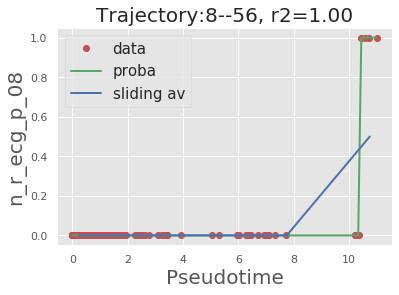

7 ('Trajectory:8--56', 'n_r_ecg_p_08', 1.0)
[('Trajectory:8--56', 'n_r_ecg_p_08', 1.0)]
n_r_ecg_p_09 BINARY
n_r_ecg_p_10 BINARY
n_p_ecg_p_01 BINARY
n_p_ecg_p_03 BINARY
n_p_ecg_p_04 BINARY
n_p_ecg_p_05 BINARY
n_p_ecg_p_06 BINARY


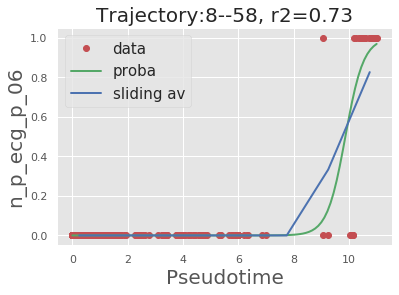

9 ('Trajectory:8--58', 'n_p_ecg_p_06', 0.734984984984985)
[('Trajectory:8--58', 'n_p_ecg_p_06', 0.734984984984985)]
n_p_ecg_p_07 BINARY
n_p_ecg_p_08 BINARY


/mnt/c/Datas/Golovenkin/clintraj_util.py:101: RuntimeWarning: invalid value encountered in true_divide
  bin_avgs = vals / counts


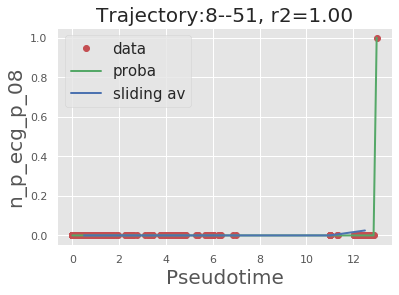

2 ('Trajectory:8--51', 'n_p_ecg_p_08', 1.0)
[('Trajectory:8--51', 'n_p_ecg_p_08', 1.0)]
n_p_ecg_p_09 BINARY
n_p_ecg_p_10 BINARY
n_p_ecg_p_11 BINARY
n_p_ecg_p_12 BINARY
fibr_ter_01 BINARY
fibr_ter_02 BINARY
fibr_ter_03 BINARY
fibr_ter_05 BINARY
fibr_ter_06 BINARY
fibr_ter_07 BINARY
fibr_ter_08 BINARY
GIPO_K BINARY
K_BLOOD CONTINUOUS


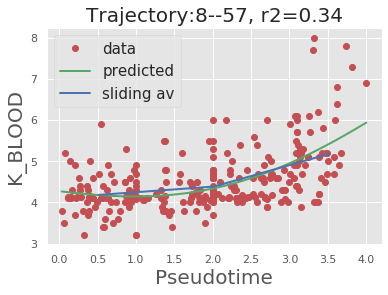

8 ('Trajectory:8--57', 'K_BLOOD', 0.34074154422150726)
[('Trajectory:8--57', 'K_BLOOD', 0.34074154422150726)]
GIPER_NA BINARY


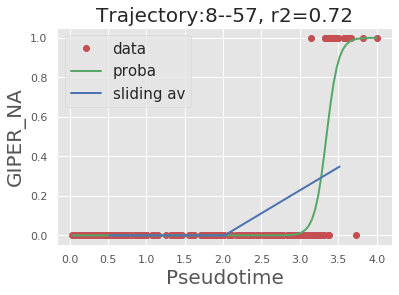

8 ('Trajectory:8--57', 'GIPER_NA', 0.7163167465696809)
[('Trajectory:8--57', 'GIPER_NA', 0.7163167465696809)]
NA_BLOOD CONTINUOUS
ALT_BLOOD CONTINUOUS
AST_BLOOD CONTINUOUS
L_BLOOD CONTINUOUS
ROE CONTINUOUS
TIME_B_S ORDINAL
R_AB_1_n ORDINAL
R_AB_2_n ORDINAL


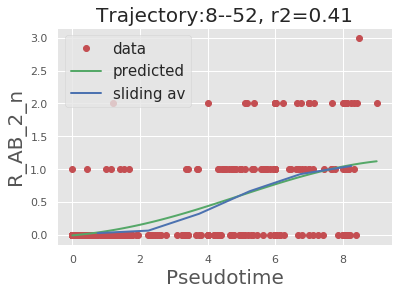

3 ('Trajectory:8--52', 'R_AB_2_n', 0.40570377274712877)
[('Trajectory:8--52', 'R_AB_2_n', 0.40570377274712877)]
R_AB_3_n ORDINAL


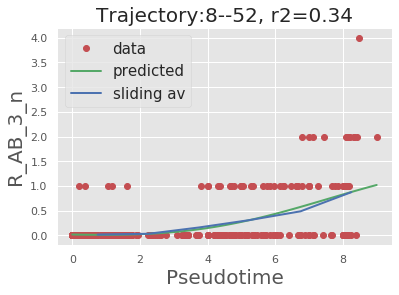

3 ('Trajectory:8--52', 'R_AB_3_n', 0.3428747053029869)
[('Trajectory:8--52', 'R_AB_3_n', 0.3428747053029869)]
NITR_S ORDINAL
NA_R_1_n ORDINAL
NA_R_2_n ORDINAL


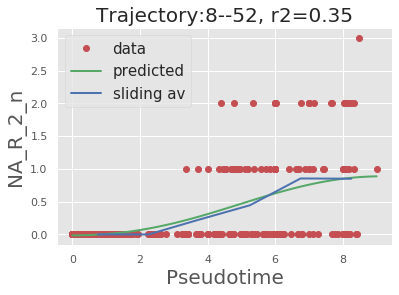

3 ('Trajectory:8--52', 'NA_R_2_n', 0.3544233131890494)
[('Trajectory:8--52', 'NA_R_2_n', 0.3544233131890494)]
NA_R_3_n ORDINAL


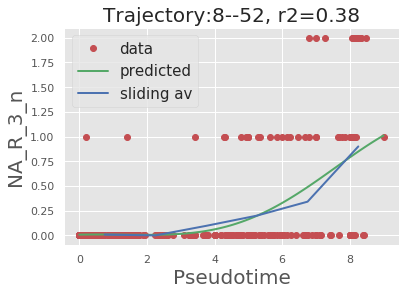

3 ('Trajectory:8--52', 'NA_R_3_n', 0.3762573981645029)
[('Trajectory:8--52', 'NA_R_3_n', 0.3762573981645029)]
NOT_NA_1_n ORDINAL
NOT_NA_2_n ORDINAL


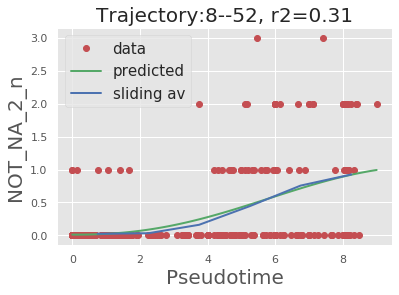

3 ('Trajectory:8--52', 'NOT_NA_2_n', 0.3059945356104885)
[('Trajectory:8--52', 'NOT_NA_2_n', 0.3059945356104885)]
NOT_NA_3_n ORDINAL


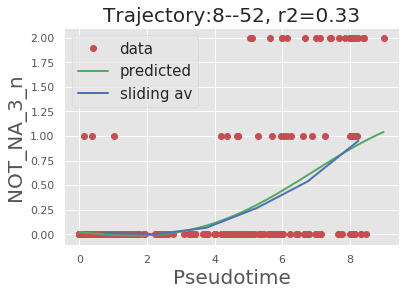

3 ('Trajectory:8--52', 'NOT_NA_3_n', 0.33355676217167995)
[('Trajectory:8--52', 'NOT_NA_3_n', 0.33355676217167995)]
LID_S_n BINARY
B_BLOK_S_n BINARY
ANT_CA_S_n BINARY
GEPAR_S_n BINARY
ASP_S_n BINARY
TIKL_S_n BINARY
TRENT_S_n BINARY
FIBR_PREDS BINARY
PREDS_TAH BINARY
JELUD_TAH BINARY


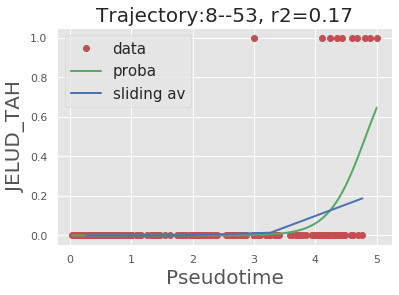

4 ('Trajectory:8--53', 'JELUD_TAH', 0.16875000000000007)
[('Trajectory:8--53', 'JELUD_TAH', 0.16875000000000007)]
FIBR_JELUD BINARY
A_V_BLOK BINARY
OTEK_LANC BINARY
RAZRIV BINARY


/mnt/c/Datas/Golovenkin/clintraj_util.py:101: RuntimeWarning: invalid value encountered in true_divide
  bin_avgs = vals / counts


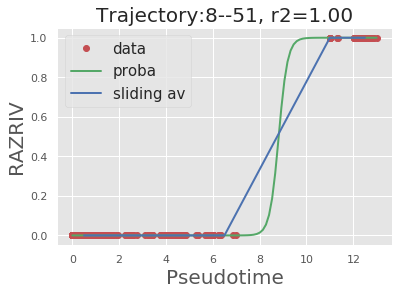

2 ('Trajectory:8--51', 'RAZRIV', 1.0)
[('Trajectory:8--51', 'RAZRIV', 1.0)]
DRESSLER BINARY
ZSN BINARY
REC_IM BINARY
P_IM_STEN BINARY
LET_IS_0 BINARY


/mnt/c/Datas/Golovenkin/clintraj_util.py:101: RuntimeWarning: invalid value encountered in true_divide
  bin_avgs = vals / counts


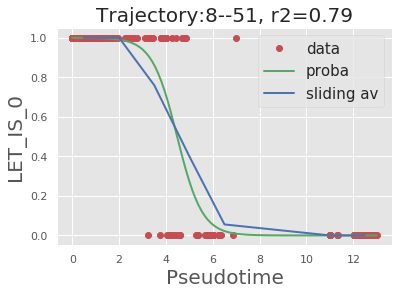

2 ('Trajectory:8--51', 'LET_IS_0', 0.7934322033898304)


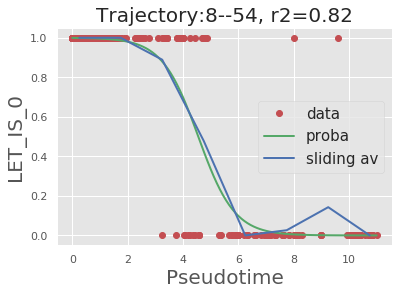

5 ('Trajectory:8--54', 'LET_IS_0', 0.8230730730730731)
[('Trajectory:8--51', 'LET_IS_0', 0.7934322033898304), ('Trajectory:8--54', 'LET_IS_0', 0.8230730730730731)]
LET_IS_1 BINARY


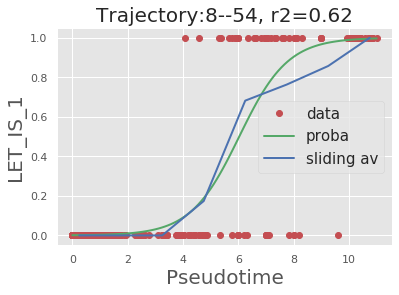

5 ('Trajectory:8--54', 'LET_IS_1', 0.6209135607851968)
[('Trajectory:8--54', 'LET_IS_1', 0.6209135607851968)]
LET_IS_2 BINARY


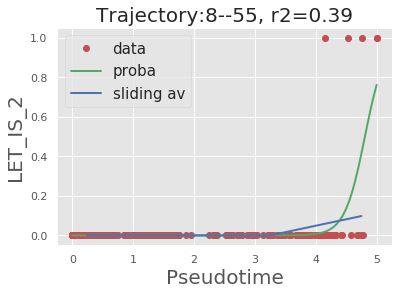

6 ('Trajectory:8--55', 'LET_IS_2', 0.39271844660194166)
[('Trajectory:8--55', 'LET_IS_2', 0.39271844660194166)]
LET_IS_3 BINARY


/mnt/c/Datas/Golovenkin/clintraj_util.py:101: RuntimeWarning: invalid value encountered in true_divide
  bin_avgs = vals / counts


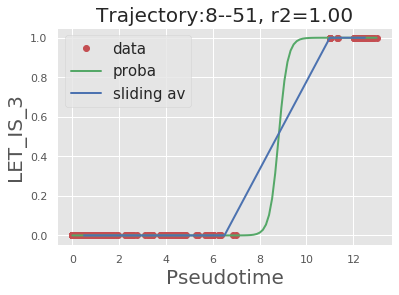

2 ('Trajectory:8--51', 'LET_IS_3', 1.0)
[('Trajectory:8--51', 'LET_IS_3', 1.0)]
LET_IS_4 BINARY


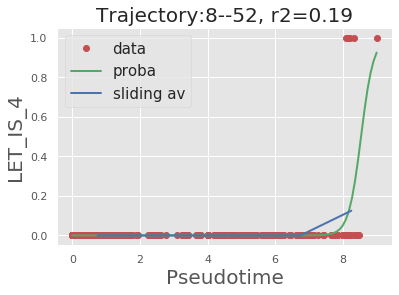

3 ('Trajectory:8--52', 'LET_IS_4', 0.1905213270142181)
[('Trajectory:8--52', 'LET_IS_4', 0.1905213270142181)]
LET_IS_5 BINARY
LET_IS_6 BINARY
LET_IS_7 BINARY


In [117]:
# associate trajectories with variables by regression

reload(clintraj_eltree)
from clintraj_eltree import regression_of_variable_with_trajectories


R2_Threshold = 0.3
R2_Threshold_For_Complications = 0.1
producePlot = True
all_trajectory_variable_associations = {}
complication_variables = ['LET_IS_0','LET_IS_1','LET_IS_2','LET_IS_3','LET_IS_4','LET_IS_5','LET_IS_6','LET_IS_7','FIBR_PREDS','PREDS_TAH','JELUD_TAH','FIBR_JELUD','A_V_BLOK','OTEK_LANC','RAZRIV','DRESSLER','ZSN','REC_IM','P_IM_STEN']

for k,var in enumerate(variable_names):
    print(var,variable_types[variable_names.index(var)])
    if var in complication_variables:
        r2th = R2_Threshold_For_Complications
    else:
        r2th = R2_Threshold
    List_of_Associations = regression_of_variable_with_trajectories(PseudoTimeTraj,var,variable_names,
                                                                    variable_types,X_original,R2_Threshold=r2th,
                                                                    producePlot=producePlot,
                                                                    Continuous_Regression_Type='gpr',
                                                                    verbose=True)
    if len(List_of_Associations)>0:
        print(List_of_Associations)
        all_trajectory_variable_associations[var]=List_of_Associations

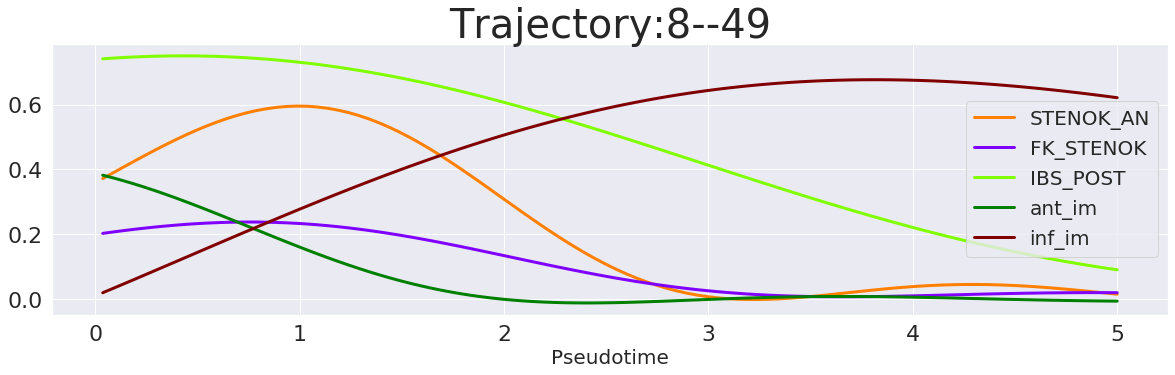

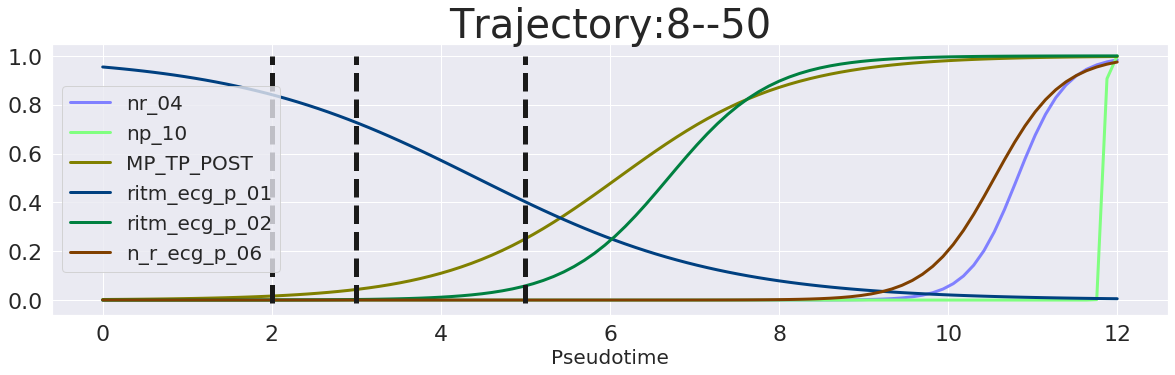

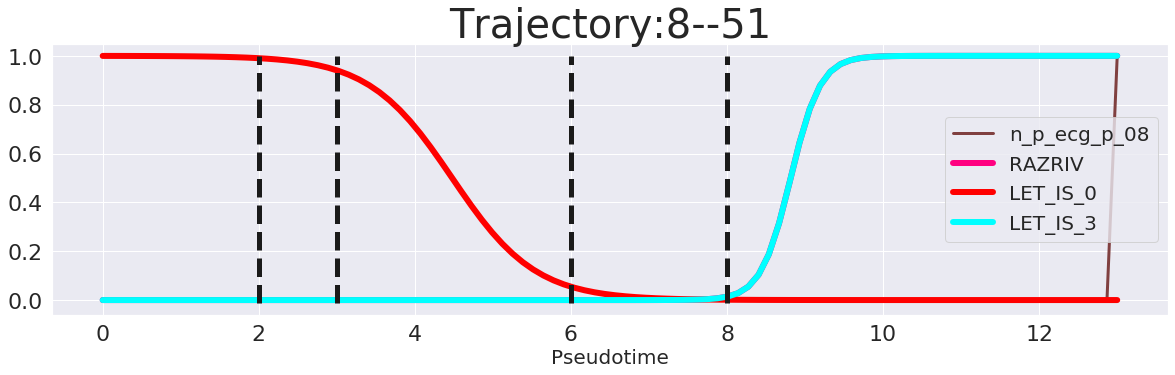

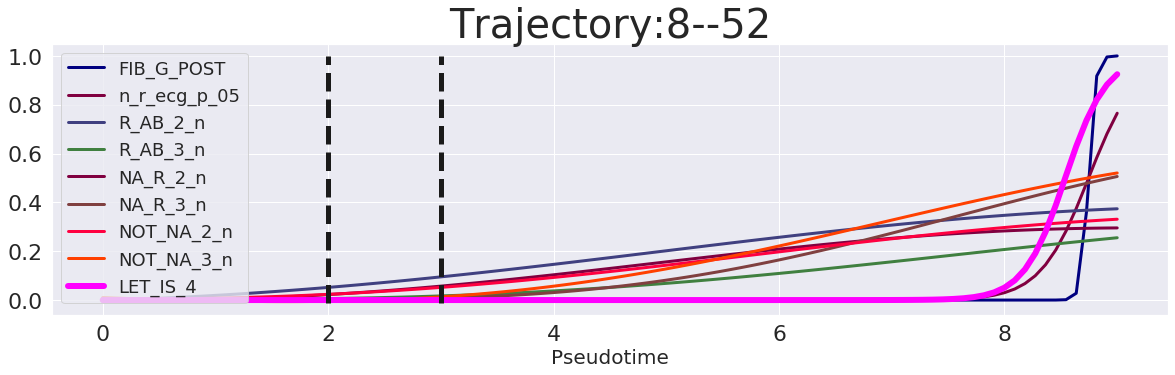

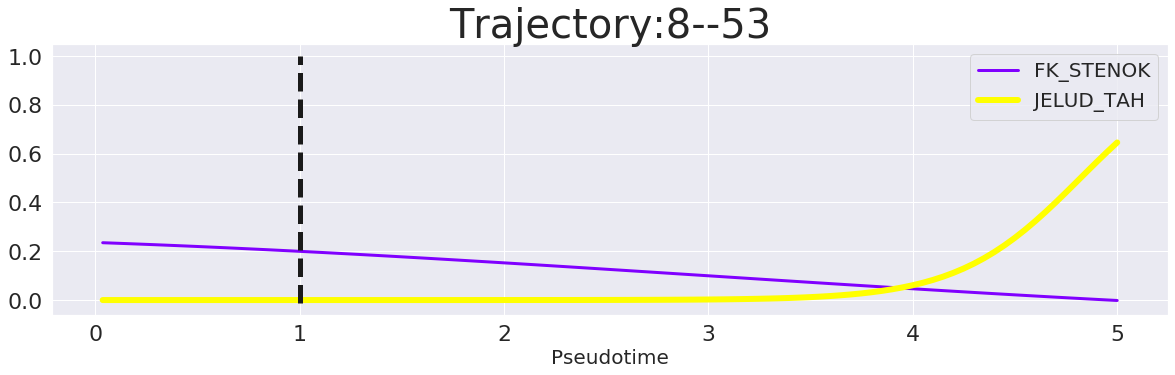

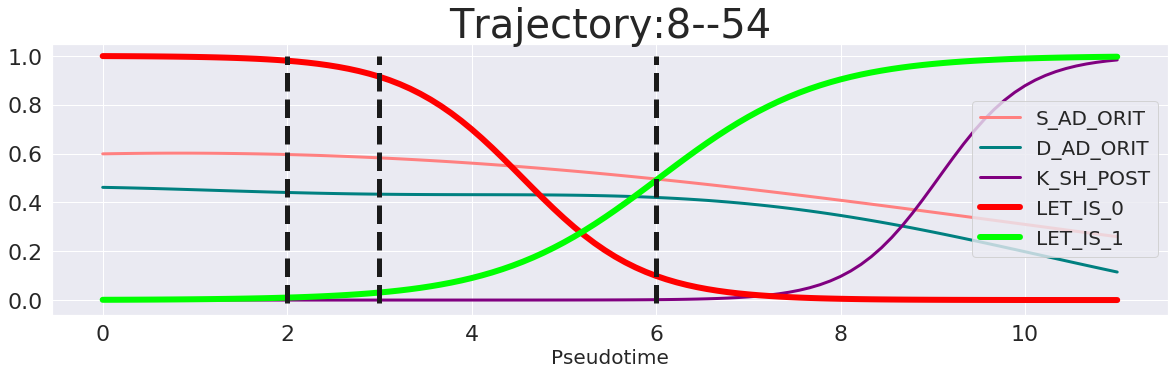

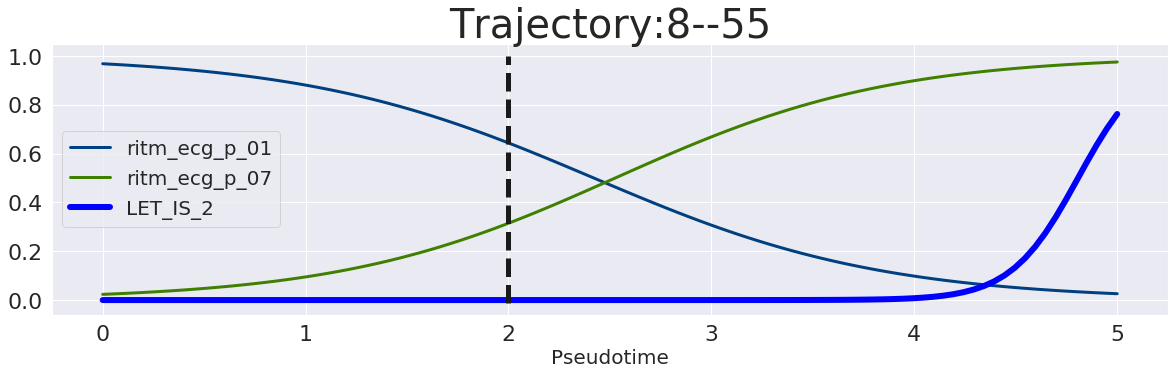

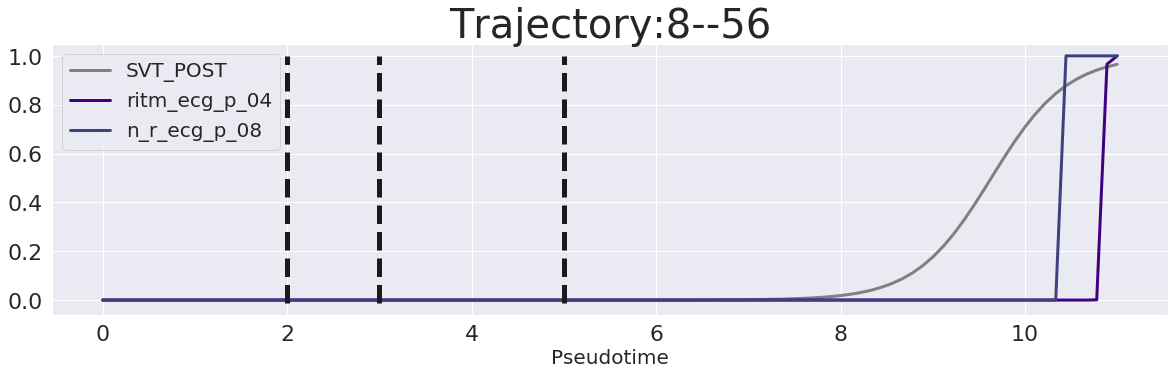

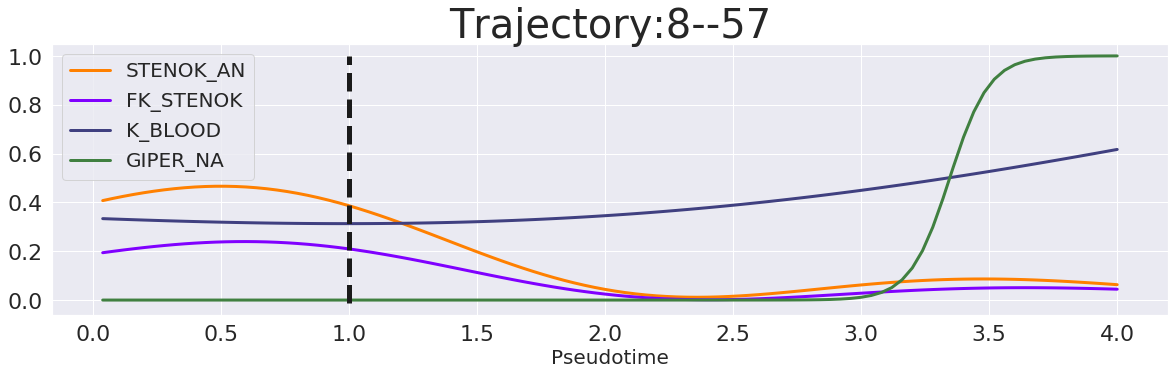

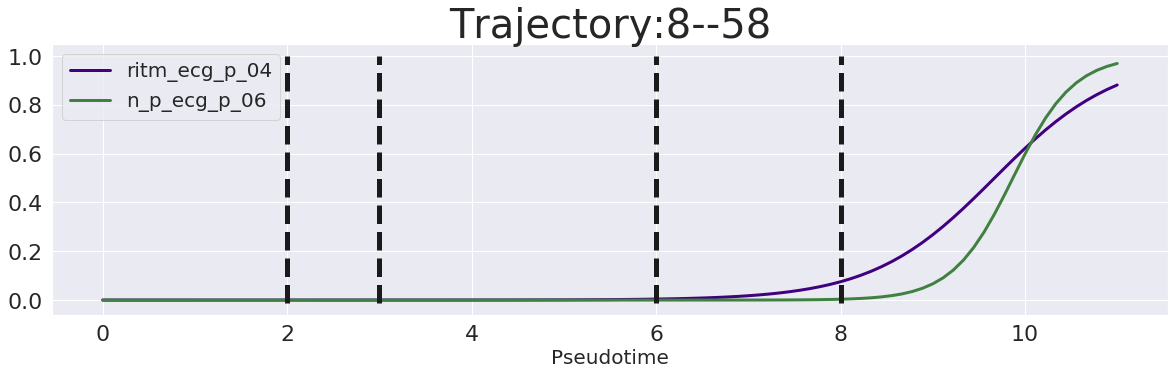

In [118]:
# Draw pseudotime dependencies of variables significantly associated with trajectories

reload(clintraj_util)
from clintraj_util import get_standard_color_seq


color_seq = get_standard_color_seq()
var_colors = {}
all_vars = list(all_trajectory_variable_associations.keys())
complication_variables = ['LET_IS_0','LET_IS_1','LET_IS_2','LET_IS_3','LET_IS_4','LET_IS_5','LET_IS_6','LET_IS_7','FIBR_PREDS','PREDS_TAH','JELUD_TAH','FIBR_JELUD','A_V_BLOK','OTEK_LANC','RAZRIV','DRESSLER','ZSN','REC_IM','P_IM_STEN']
k=0
for var in complication_variables:
    if var in all_trajectory_variable_associations:
        #print(k)
        var_colors[var] = color_seq[k]
        k = k+1
        if k>len(color_seq)-1:
            k=0
for var in all_vars:
    if not var in complication_variables:
        #print(k)
        var_colors[var] = color_seq[k]
        k = k+1
        if k>len(color_seq)-1:
            k=0

sns.set(font_scale=2)

min_val = 1
max_val = 0

for pstt in PseudoTimeTraj:
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    fig = plt.figure(figsize=(20, 5))
    for var in all_trajectory_variable_associations:
        associations = all_trajectory_variable_associations[var]
        for assoc in associations:
            trajn = assoc[0]
            if trajn==TrajName:
                var = assoc[1]
                if var in complication_variables:
                    vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                               linewidth=6,draw_datapoints=False)
                else:
                    vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                               linewidth=3,draw_datapoints=False)
                if vals is not None:
                    min_val = min(min_val,min(vals))
                    max_val = max(max_val,max(vals))
                #else:
                #    print(var,TrajName,' regressor is not found')
    bp = pstt['BranchingPoints']
    for x in bp:
        plt.plot([x,x],[min_val,max_val],'k--',linewidth=5)
    if TrajName.endswith('52'):
        plt.legend(fontsize=18,loc='upper left')
    else:
        plt.legend(fontsize=20)
    plt.title(TrajName,fontsize=40)
    plt.savefig(TrajName+'.png', format='png', dpi=300)
    plt.show()

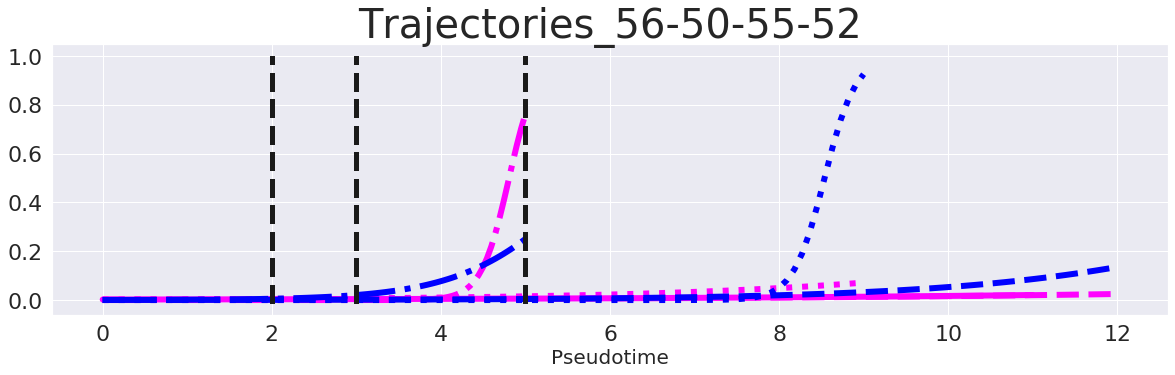

In [119]:
## Show selected variable dynamics on several trajectories simultaneously

reload(clintraj_eltree)
from clintraj_eltree import draw_pseudotime_dependence


color_seq = get_standard_color_seq()
var_colors = {}
line_styles = ['-','--','-.',':']

trajs_endpoints = [56,50,55,52]
trajs_endpoints_str = [str(ep) for ep in trajs_endpoints]
trajs = len(trajs_endpoints)*[None]
for pstt in PseudoTimeTraj:
    traj = pstt['Trajectory']
    if traj[-1] in trajs_endpoints:
        trajs[trajs_endpoints.index(traj[-1])] = pstt


#all_vars = ['MP_TP_POST','ritm_ecg_p_01','ritm_ecg_p_07']
#all_vars = ['MP_TP_POST','ritm_ecg_p_01',  'ritm_ecg_p_07', 'NA_R_2_n']
all_vars = ['LET_IS_2','LET_IS_4']
if False:
    all_vars = []
    for var in all_trajectory_variable_associations:
        associations = all_trajectory_variable_associations[var]
        for assoc in associations:
            trajn = assoc[0]
            if trajn[-2:] in trajs_endpoints_str:
                all_vars.append(var)
    all_vars = list(set(all_vars))

for k,var in enumerate(all_vars):
    var_colors[var] = color_seq[k]
var_colors[all_vars[0]] = [1,0,1]
var_colors[all_vars[1]] = [0,0,1]
#var_colors[all_vars[0]] = [0,1,0]
#var_colors[all_vars[1]] = [0,0.5,0.5]
#var_colors[all_vars[2]] = [0.5,0.5,0]
#var_colors[all_vars[3]] = [0.5,0,0.5]
    
title = 'Trajectories_'+'-'.join(trajs_endpoints_str)
fig = plt.figure(figsize=(20, 5))
bp = []
for var in all_vars:
    for p,pstt in enumerate(trajs):
        if var in complication_variables:
            vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                       linewidth=6,draw_datapoints=False,label=var+'_'+trajs_endpoints_str[p],
                                       linestyle=line_styles[p])
        else:
            vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                       linewidth=3,draw_datapoints=False,label=var+'_'+trajs_endpoints_str[p],
                                       linestyle=line_styles[p])
            #plt.legend(fontsize=20)
            #plt.ylim([0,1])
        if vals is not None:
            min_val = min(min_val,min(vals))
            max_val = max(max_val,max(vals))
        bp1 = pstt['BranchingPoints']
        bp = bp+bp1
    for x in bp:
        plt.plot([x,x],[min_val,max_val],'k--',linewidth=5)
    #plt.legend(fontsize=20)
    plt.title(title,fontsize=40)
    plt.savefig(title+'.png', format='png', dpi=300)
plt.show()
    

['JELUD_TAH', 'K_BLOOD', 'GIPER_NA', 'ant_im', 'IBS_POST', 'inf_im', 'STENOK_AN', 'FK_STENOK', 'n_p_ecg_p_06', 'ritm_ecg_p_04', 'SVT_POST', 'n_r_ecg_p_08', 'LET_IS_3', 'n_p_ecg_p_08', 'RAZRIV', 'LET_IS_0', 'LET_IS_1', 'K_SH_POST', 'S_AD_ORIT', 'D_AD_ORIT', 'NA_R_3_n', 'NA_R_2_n', 'FIB_G_POST', 'R_AB_2_n', 'NOT_NA_3_n', 'LET_IS_4', 'NOT_NA_2_n', 'n_r_ecg_p_05', 'R_AB_3_n', 'ritm_ecg_p_07', 'LET_IS_2', 'ritm_ecg_p_01', 'np_10', 'MP_TP_POST', 'n_r_ecg_p_06', 'nr_04', 'ritm_ecg_p_02']



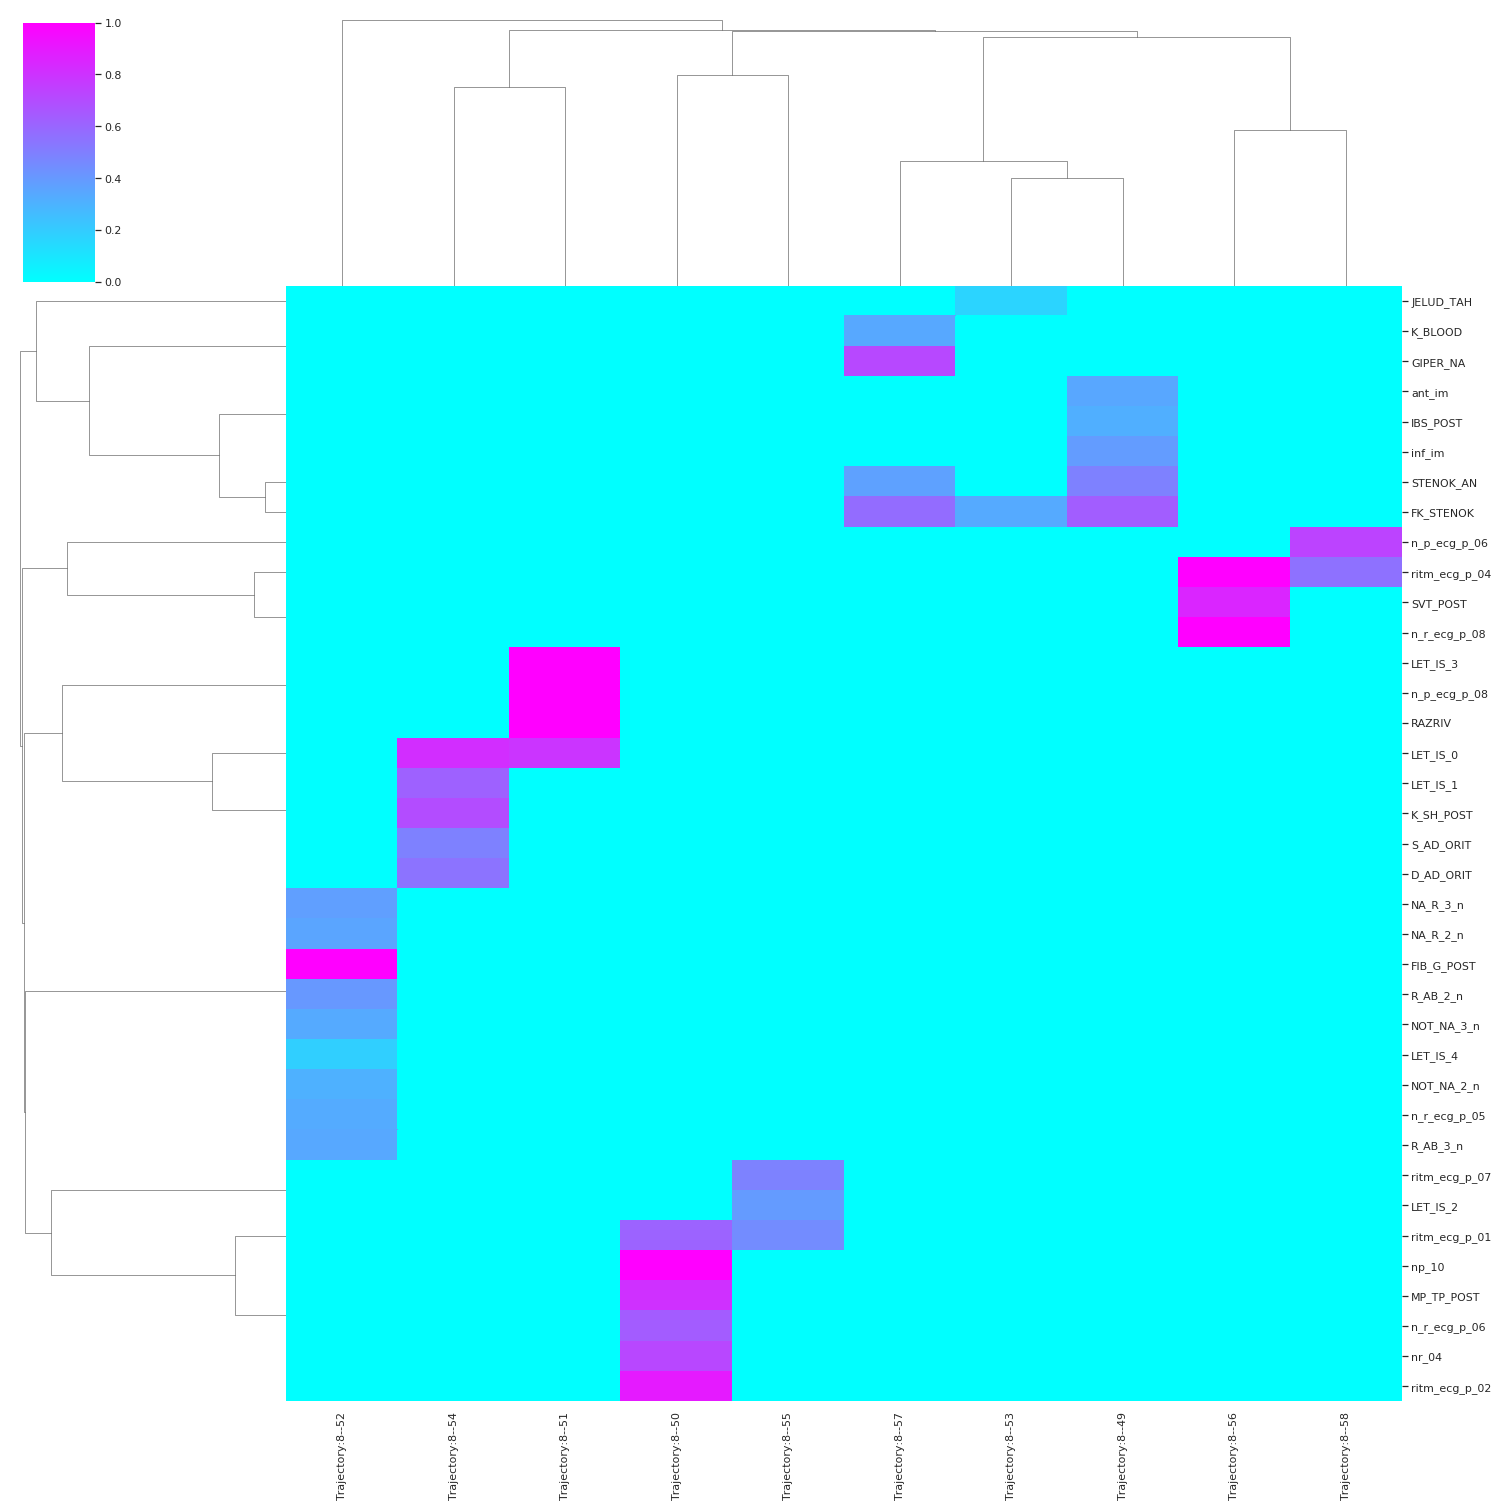

In [120]:
# Visualize associations between variables and trajectories

matrix_of_scores,keys,objects = get_matrix_of_association_scores(all_trajectory_variable_associations)

sns.set(color_codes=True)
#g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(20, 20),cmap='cool')
objects_reordered = [objects[ind] for ind in g.dendrogram_col.reordered_ind]
keys_reordered = [keys[ind] for ind in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_xticklabels(objects_reordered)
g.ax_heatmap.set_yticklabels(keys_reordered)
print(keys_reordered)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.savefig('associations_trajectories.png', format='png', dpi=300)
print()


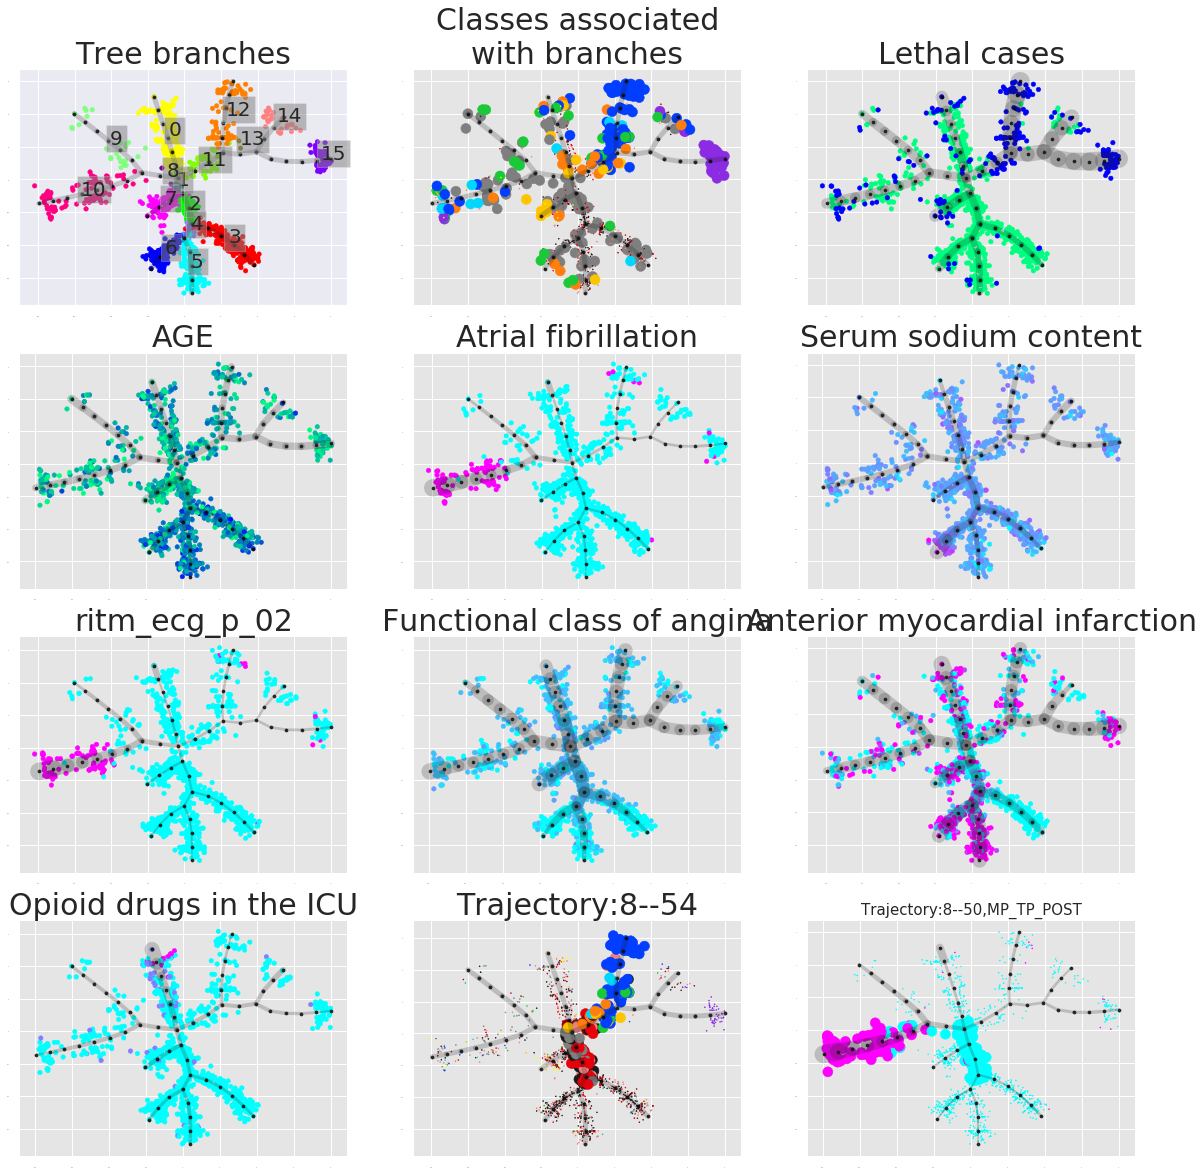

In [42]:
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

# visualizing some of the results on top of the tree

n_subplots_x, n_subplots_y = 4, 3
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 20))
title_font_size = 30

sns.set(font_scale=0,palette='bright')

# Visualize partionining of data by branches
i=1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          showBranchNumbers=True,Color_by_partitioning=True,visualize_partition=vec_labels_by_branches)
plt.title('Tree branches',fontsize=title_font_size)

# Show only points of classes strongly associated with branches
i=i+1
list_of_node_class_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,'CLASS',color,'CATEGORICAL',
                                                            score_threshold=0.7,
                                                            Negative_Enrichment=False,
                                                            Minimal_number_of_points=5,verbose=False)
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Classes associated\nwith branches',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Visualize_Branch_Class_Associations=list_of_node_class_associations)


# Visualize survival risk
i=i+1
feature='LET_IS_0'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Lethal cases',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Invert_Edge_Value=True,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature,cmap='winter')

# Visualize patient age
i=i+1
feature='AGE'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('AGE',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=10,Color_by_feature=feature, Feature_Edge_Width=feature,
                          vmin=30,vmax=80,cmap='winter')


# Visualize cases of cardiogenic shock
i=i+1
feature='ritm_ecg_p_02'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Atrial fibrillation',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# Visualize Serum sodium content NA_BLOOD
i=i+1
feature='NA_BLOOD'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Serum sodium content',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# ritm_ecg_p_02 - example of a strong association with binary variable
i=i+1
feature='ritm_ecg_p_02'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title(feature,fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# Visualize Functional class of angina FK_STENOK
i=i+1
feature='FK_STENOK'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Functional class of angina',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)


# Visualize anterior myocardial infarction ant_im
i=i+1
feature='ant_im'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Anterior myocardial infarction',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# Visualize use of Opioid drugs in the ICU NA_R_3_n
i=i+1
feature='NA_R_3_n'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Opioid drugs in the ICU',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)


# visualize a particular trajectory
pstt = PseudoTimeTraj[5]
points = list(pstt['Points'])
TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
i=i+1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title(TrajName,fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          highlight_subset=points,Big_Point_Size = 100,Normal_Point_Size = 1)

# visualize a particular trajectory with an associated variable 
pstt = PseudoTimeTraj[1]
points = list(pstt['Points'])
TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
i=i+1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
feature = 'MP_TP_POST'
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          highlight_subset=points,Big_Point_Size = 100,Normal_Point_Size = 1,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)
plt.title(TrajName+','+feature,fontsize=15)

plt.savefig('principal_tree_visexamples.png', format='png', dpi=400)
plt.show()

min: 0.0
max: 1.0


/home/zinovyev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


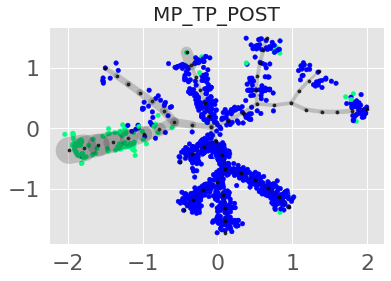

In [204]:
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

title_font_size=20
feature = 'MP_TP_POST'

print('min:',min(X_original[:,variable_names.index(feature)]))
print('max:',max(X_original[:,variable_names.index(feature)]))

ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title(feature,fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,v,mean_val,color,variable_names,
                          Min_Edge_Width=1,Max_Edge_Width=30,showNodeNumbers=False,
                           Color_by_feature=feature, Feature_Edge_Width=feature,cmap='winter')


Start computations...
PCA: 0.0077 sec
Computing LLE...
LLE: 0.71 sec
Modified LLE: 0.96 sec
Isomap: 1.6 sec
MDS: 3.7 sec
SpectralEmbedding: 0.66 sec
t-SNE: 6 sec
UMAP: 3.3 sec
TRIMAP: 1 sec
Autoencoder: 9 sec
VAE: 10 sec


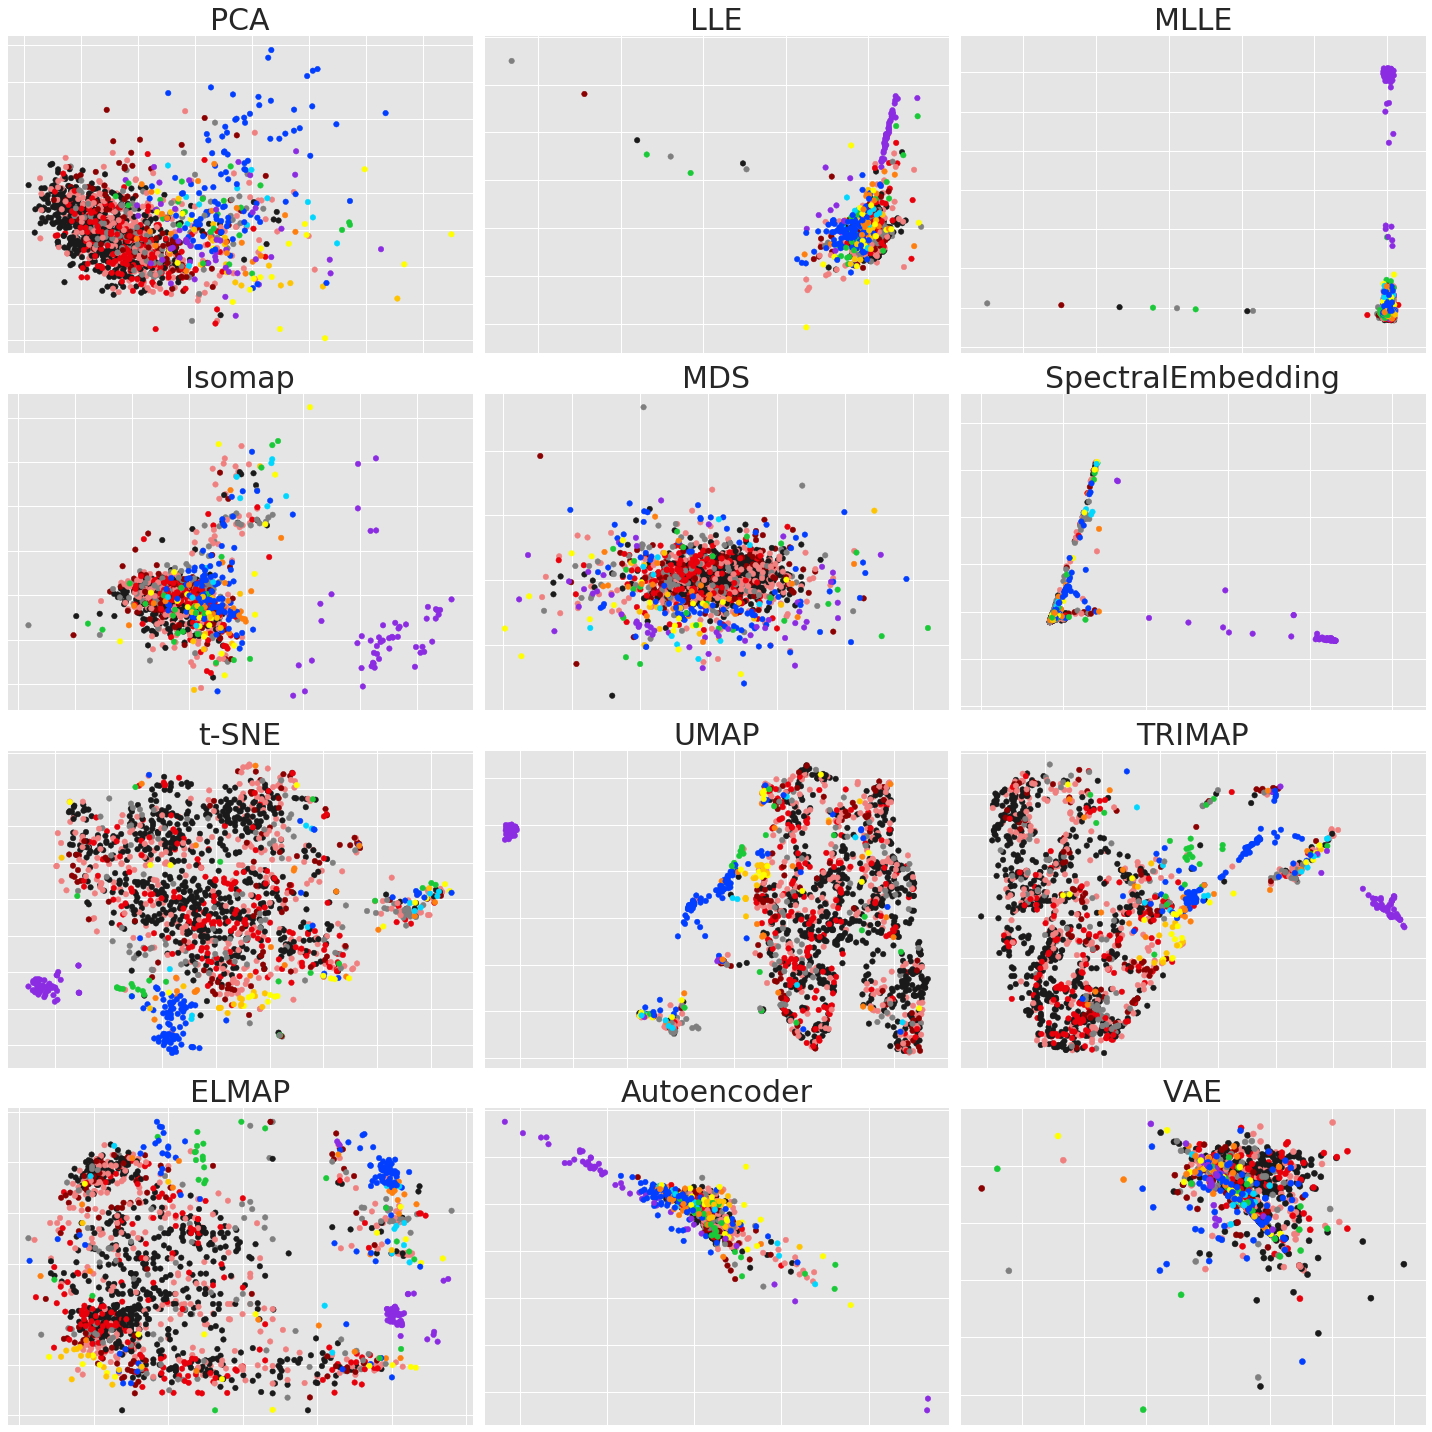

In [121]:
# Here the manifold learning is computed and saved in viz_results

sns.set(palette='bright')

viz_results = apply_panel_of_manifold_learning_methods(X,color,
    Color_by_branches=[],precomputed_results=viz_results,color_map='cool',ColorByFeature='', variable_names=[],
    ElMapFolder=ElMapFolder)
plt.savefig('manifolds_color_by_class.png', format='png', dpi=300)
plt.show()

Start computations...
PCA: 1.4e-06 sec
LLE: 4.1e-06 sec
Modified LLE: 4.1e-06 sec
Isomap: 2.6e-06 sec
MDS: 2.1e-06 sec
SpectralEmbedding: 1.7e-06 sec
t-SNE: 1.7e-06 sec
UMAP: 2.1e-06 sec
TRIMAP: 2.6e-06 sec
Autoencoder: 2.6e-06 sec
VAE: 2.6e-06 sec


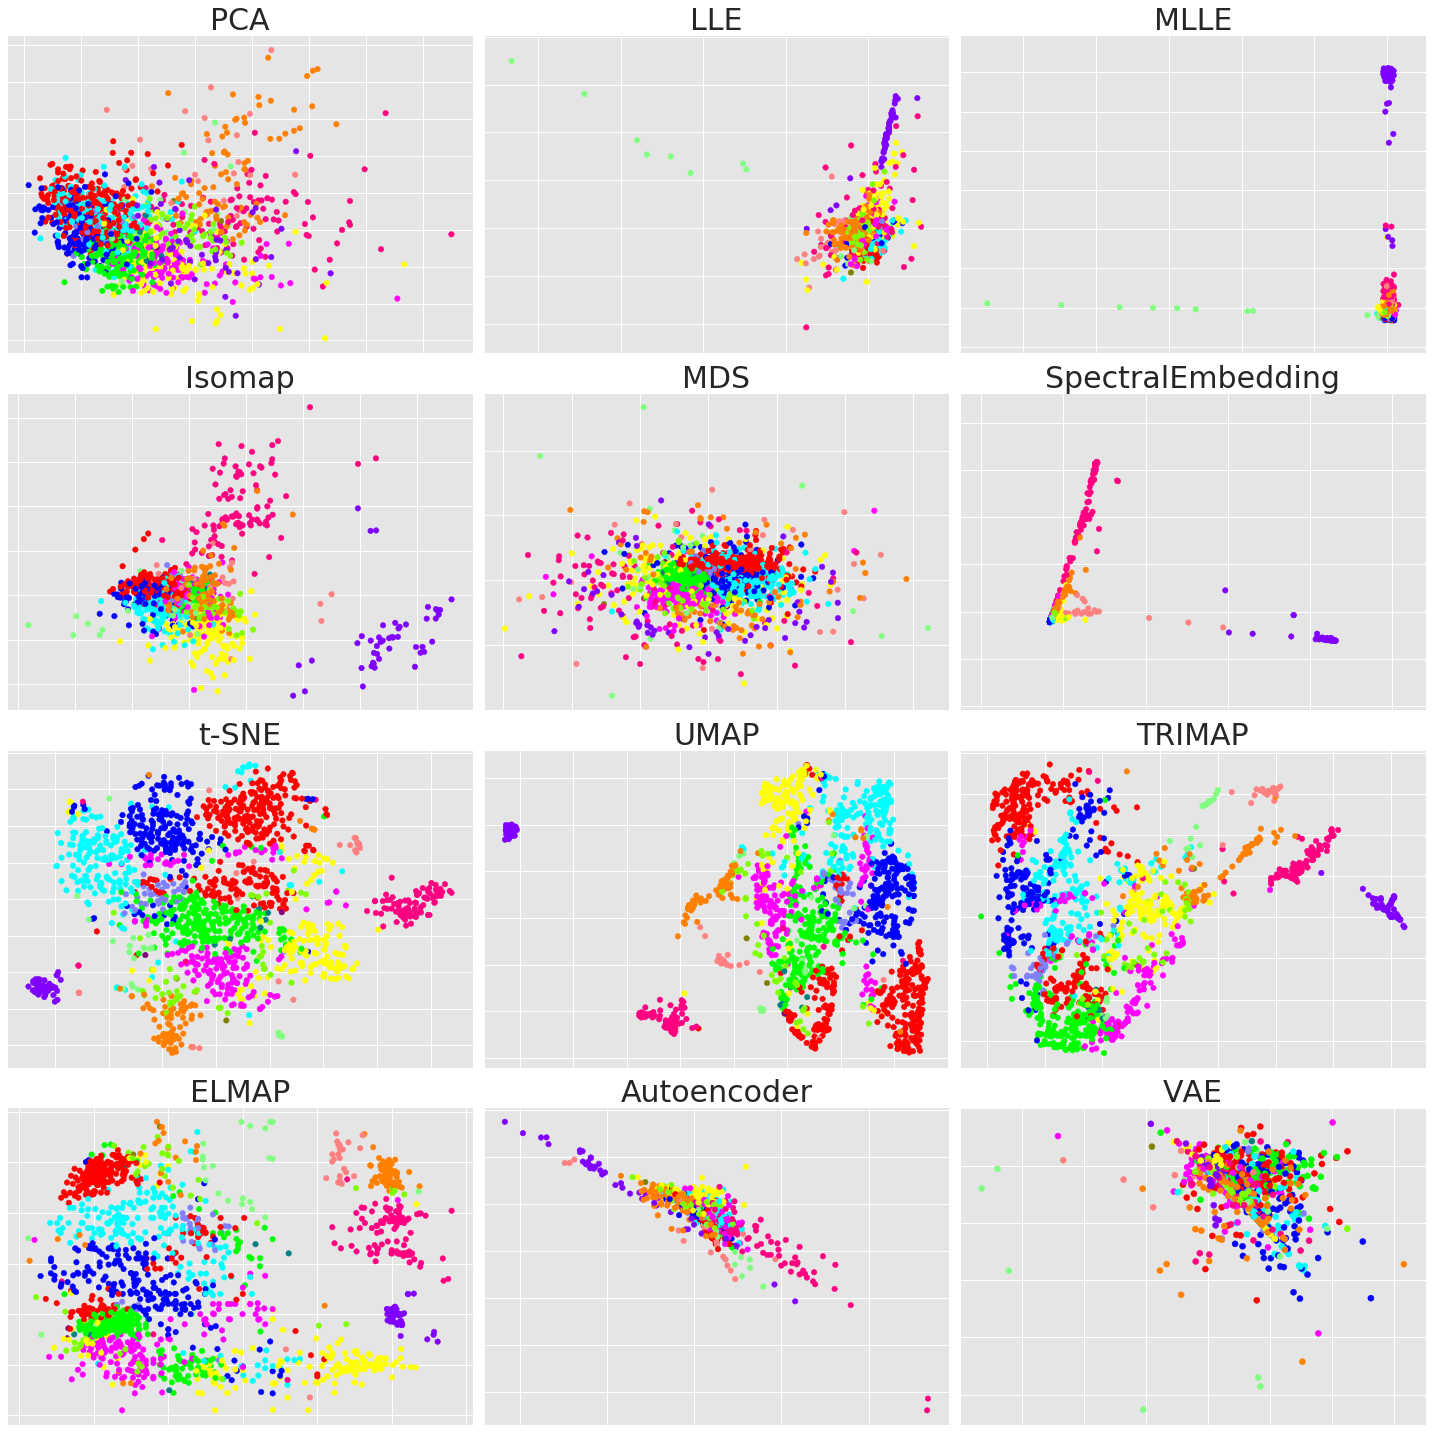

In [122]:
# Now we color by branches of the principal tree
# Here we use the results of the previous computations by specifying 'precomputed_results'

apply_panel_of_manifold_learning_methods(X,color,
    Color_by_branches=vec_labels_by_branches,precomputed_results=viz_results,color_map='cool',ColorByFeature='', variable_names=[],
    ElMapFolder=ElMapFolder)
plt.savefig('manifolds_color_by_tree_branch.png', format='png', dpi=300)
plt.show()